In [1]:
## master stress test module: includes state macro variables:
## NOTE: use br003maa_ module for model results presented in chapter 3 (without CE variable)
##       All "univstress" modules include CE variables
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## lists of states and banks within regional group to analyze:
## state/region:  if none: stlst=[]; if one only: stlst=['FL']; if multiple states aggregated: stlst=['FL','GA','AL']
stlst = ['FL','GA']
#stlst = ['NV']
#stlst = ['CA']
#stlst=[]

## exclusion list: (enter IDRSSD for each bank to exclude)
#exlst = []  ## use this as default
exlst = [2193616,665931,1212846]  ## FL,GA exclude: Raymond James, Northern Trust, Monogram Credit Card
#exlst = [2502656,3150447,2129008,2036843,3287660,2819167] # NV: USAA, Chas Schwab, Household (SB & NA), Toyota, Farm Bureau
if len(exlst)==0:
  exflg = ''
else:
  exflg = 'x'

#########################################################################
## Pick one of the next 5 lines:  
irflg = '_NoRates'  ## use this to remove rates from regressions
#irflg = '_NoRate_Big3'  ## SPECIAL: designates backtest re-run using only "big 3" vars: UE, HPI, CRE
#irflg = '_NoRate_Big4v'  ## SPECIAL: designates backtest re-run using only "big 4" vars: UE, HPI, CRE, CE
#irflg = ''  ## use this to keep rates in regressions and use all variables in regressions
#irflg = '_Big3' ## use this to keep rates in regressions but limit vars to Big3 only

############################################################
# 12/13/15: new list: brief list of only vars to use in regressions
#   (Note: can be a small number other than 3 if desired... like 4 or 5)
#big3 = ['UE','HPI','CRE']  ### list of big3 variables
#big3 = ['UE','HPI','CRE','VIX']  ### list of big3 vars + VIX
big3=[]  ## use this if Big3 not selected

## WARNING:  Select small group of unique banks here:
#rslst=[]  # IDRSSD list for ad hoc 
rslst = [598534]  ## Fidelity (GA)
#tclst=[]  # ticker list for ad hoc
tclst = ['CCBG']  ## Capital City (FL)

##########################################################################
##  NOTE:  Large bank exclusions:  Pick one of 3 options:
##  'x00':  Include all banks (do not exclude any)
##  'x18':  Exclude CCAR 18-bank group and their acquired/merged banks
##  'x31':  Exclude CCAR 31-bank group and their acquired/merged banks
xtyp = 'x18'  ## pick 'x00', 'x18', or 'x31' only, (with grpC18, use x00 only)

htyp = ''  # use this for ultcert tickers (to catch acquired/consolidated banks in history)
#htyp = 'nohist' # use this for current affiliates only

## group name: select one line only among choices:
## (note: only one group can be specified, but all groups will be available for further analysis later!)
## (this label will be used to name all output files to make it easy to locate them later)
#grp = 'grp' + 'TotUS_C18C31' + xtyp + exflg + htyp # special code:
#grp = 'grp' + 'TotUS' + xtyp + exflg + htyp # use this for TotUS target group
#grp = 'grp' + 'C18' + xtyp + exflg + htyp # use this for C18 target group
#grp = 'grp' + 'C31' + xtyp + exflg + htyp # use this for C31 target group
grp = 'grp' + ''.join(stlst) + xtyp + exflg + htyp # use this for statelist (1, 2, or 3 states only)
#grp = 'grp' + 'CapFid_'+ ''.join(stlst) + xtyp + exflg + htyp # use this for any other grouping
#grp = 'grp' + 'CapFid' # use this for any other grouping (fill in a unique name into blanks)

USflg = 'Yes'  # 'Yes' means run TotUSx00,x18,x31 groups, 'No' means do not run all 3 TotUS groups
Cxflg = 'No'  # 'Yes' means run C18x00 and C31x00 groups, 'No' means do not run both of those groups
indiv = 'No'  # 'Yes' means run indiv banks/tickers, 'No' means do not run indiv banks/tickers

## flags for var transforms to use: orig, lag, exp
vtyp = 2  # 0: Original vars+CE, no transformations; 1: lags (UE,HPI,CRE,CE 4q lags); 2: Lags & sUE23
qtyp = 4  # 4: rolling 4q NCO rates, 1: 1qtr NCO rates (annualized)

if qtyp == 1:
  rtyp = "1q"
  rskp = 0
  curlst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']
elif qtyp == 4:
  rtyp = "4q"
  rskp = 3
  curlst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
else:
  rskp = 999
  rclst = []  # force error

cbo = ['Orig', 'Lags', 'Lags_sUE2']  # descriptors for vtyp code
styp = cbo[vtyp]  # selects one of the cbo codes based on vtyp entry.

grporig = grp
grp

'grpFLGAx18x'

In [3]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

hs['DJ'] = hs['DJ']/1000
cc['DJ'] = cc['DJ']/1000

cc2 = cc.dropna(how='any',axis=1)  # remove any vars that are missing in any ccar year (removes T5y, Prime)
cccol = list(cc2.columns)[3:]
hs2 = hs[['Date']+cccol]
hs2.set_index('Date', drop=True, inplace=True)
hs2 = hs2.ix['2000-01':]
hscol = list(hs2.columns)  # original ccar variables

In [4]:
## Tickers to exclude from aggregates: CCAR 18-bank and 31-bank groups:
c18tic = ['ALLY','AXP','BAC','BBT','BK','C','COF','FITB','GS','JPM','KEY','MS','PNC','RF','STI','STT','USB','WFC']
c31tic = c18tic + ['BMO','BBVA','CFG','CMA','DB','DFS','HSBC','HBAN','MTB','MTU','NTRS','SAN','ZION']

In [5]:
#########################################################
## section to download CE and state CE & UE variables
#########################################################

In [6]:
## prepare to gather nominal GDP from FRED database:
start = pd.datetime(2000,1,1)
end = pd.datetime(2018,6,30)

In [7]:
if len(stlst) == 0:
  print("No states selected.")
else:
  print("OK to proceed.")

OK to proceed.


In [8]:
## process only if len(stlst)>0:
uestq = []
if len(stlst) > 0:
  uelst = [s + 'UR' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLUR' = FL unemp rate 
  lflst = [s + 'LF' for s in stlst]  ## codes in FRED database: 'FLLF' = FL labor force
  ## NOTE:  use labor force values as weightings for regional aggregates of state UE rates
  uest = web.DataReader(uelst+lflst,'fred',start,end)  ## download data in uest dataframe
  uest['UE_'+''.join(stlst)] = uest.apply(lambda x:np.average(x[[z+'UR' for z in stlst]],\
                                           weights=x[[z+'LF' for z in stlst]]),axis=1)
  uestq = uest.resample('Q').mean()

if len(uestq)>0:
  print(uestq.head(2))
else:
  print('No state UE')

                FLUR      GAUR          FLLF          GALF   UE_FLGA
DATE                                                                
2000-03-31  3.700000  3.633333  7.788082e+06  4.205825e+06  3.676629
2000-06-30  3.733333  3.700000  7.832881e+06  4.222884e+06  3.721663


In [9]:
celst = [] # CE codes for FRED database
telst = [] # TotEmployment codes for FRED database

if len(stlst)>0: celst = [s + 'CONS' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLCE' = FL constr emp
celst = ['USCONS'] + celst
if len(stlst)>0: telst = [s + 'NA' for s in stlst]  ## FLNA is Florida total non-farm employment
telst = ['PAYEMS'] + telst
cest = web.DataReader(celst+telst,'fred',start,end)  ## download data in uest dataframe
if len(stlst)>0:
  cest[''.join(stlst)+'CONS'] = cest.apply(lambda x:np.sum(x[[z+'CONS' for z in stlst]]),axis=1)
  cest[''.join(stlst)+'NA'] = cest.apply(lambda x:np.sum(x[[z+'NA' for z in stlst]]),axis=1)
cest[['USCONS','PAYEMS']] = cest[['USCONS','PAYEMS']].astype('float')
cestq = cest.resample('Q').mean()
cestq.ix['2017']

USCONS      FLCONS      GACONS         PAYEMS         FLNA  \
DATE                                                                          
2017-03-31  6904.666667  499.866667  182.966667  145853.666667  8531.633333   
2017-06-30  6927.000000  503.933333  182.833333  146327.000000  8569.166667   
2017-09-30  6955.666667  498.366667  182.000000  146880.000000  8542.400000   
2017-12-31  7030.000000  514.166667  188.033333  147436.333333  8635.366667   

                   GANA    FLGACONS        FLGANA  
DATE                                               
2017-03-31  4427.966667  682.833333  12959.600000  
2017-06-30  4442.766667  686.766667  13011.933333  
2017-09-30  4458.900000  680.366667  13001.300000  
2017-12-31  4483.866667  702.200000  13119.233333

In [10]:
cestq['CE'] = cestq['USCONS']*100 / cestq['PAYEMS']
if len(stlst)>0: cestq['CE_'+''.join(stlst)] = cestq[''.join(stlst)+'CONS']*100 / cestq[''.join(stlst)+'NA']
cestq.tail()

USCONS      FLCONS      GACONS         PAYEMS         FLNA  \
DATE                                                                          
2017-06-30  6927.000000  503.933333  182.833333  146327.000000  8569.166667   
2017-09-30  6955.666667  498.366667  182.000000  146880.000000  8542.400000   
2017-12-31  7030.000000  514.166667  188.033333  147436.333333  8635.366667   
2018-03-31  7143.666667  531.266667  192.400000  148068.666667  8698.833333   
2018-06-30  7202.666667  537.066667  198.066667  148703.000000  8750.033333   

                   GANA    FLGACONS        FLGANA        CE   CE_FLGA  
DATE                                                                   
2017-06-30  4442.766667  686.766667  13011.933333  4.733918  5.277976  
2017-09-30  4458.900000  680.366667  13001.300000  4.735612  5.233066  
2017-12-31  4483.866667  702.200000  13119.233333  4.768160  5.352447  
2018-03-31  4503.000000  723.666667  13201.833333  4.824563  5.481562  
2018-06-30  4519.500000  735.133333  13269.533333  4.843659  5.540009

In [11]:
if 'CE' not in list(hs2.columns): 
  hs2 = hs2.merge(cestq[['CE']],how='left',left_index=True, right_index=True)
  if len(stlst)>0: 
    hs2 = hs2.merge(cestq[['CE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
    hs2 = hs2.merge(uestq[['UE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
hs2.tail()

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T10y  BBB  Mort      DJ  \
Date                                                                           
2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4   2.2  4.1   3.8  23.277   
2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6   2.5  4.2   4.2  24.508   
2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9   2.3  4.0   4.0  25.125   
2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0   2.3  3.9   3.9  26.149   
2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2   2.4  4.0   3.9  27.673   

              HPI    CRE   VIX        CE   CE_FLGA   UE_FLGA  
Date                                                          
2016-12-31  184.0  269.0  22.5  4.685861  5.200548  4.944684  
2017-03-31  187.0  262.0  13.1  4.733969  5.268938  4.722285  
2017-06-30  190.0  272.0  16.0  4.733918  5.277976  4.400068  
2017-09-30  193.0  275.0  16.0  4.735612  5.233066  4.178191  
2017-12-31  194.0  279.0  13.1  4.768160  5.352447  4.100611

In [12]:
### remove all interest rate variables: (They interfere with scenario forecasts.)
xvr = ['Mort','T3m','T5y','T10y','Prime','BBB'] ## xvr: interest rate CCAR vars to exclude from regressions

### ALWAYS remove int rates for this set of regressions for CE ,CE_st and UE_st variables!!!!
cccol = [x for x in cccol if x not in xvr]  ## removes interest rate vars from cccol (ccar var columns)
cccol

['rGDPg', 'nGDPg', 'rDIg', 'nDIg', 'UE', 'CPI', 'DJ', 'HPI', 'CRE', 'VIX']

In [13]:
## 3-var models:
## hs2, cc2 have removed T5y and Prime since those are not in CCAR 2012 or 2013 variables
hsy = hs2.copy()
hsz = hs2.copy()
hsz['Intercept'] = 1.0
hsz.reset_index(drop=False,inplace=True)
ccs = cc2.copy()
ccs.sort_index(by=['Scen','Date'],inplace=True)
ccs['Intercept'] = 1.0
svlst = [x for x in list(hs2.columns) if x not in hscol]
curlst = svlst
topn = 1  # number of final models to review (use topn=1 for production)
topx = 2  # number of 2-var pairs to allow in final 3 for 3-var models
curlst

['CE', 'CE_FLGA', 'UE_FLGA']

In [14]:
### build 3-var models:

In [15]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [16]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [17]:
# function to select topn models for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))


In [18]:
df3b.to_csv(grp+"_3var_stvar_params.csv")

In [19]:
grp+"_3var_stvar_params.csv"

'grpFLGAx18x_3var_stvar_params.csv'

In [20]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [21]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 3-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 4-var combo
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 4-var models
df4b.index = np.arange(len(df4b))


In [22]:
df4b.to_csv(grp+"_4var_stvar_params.csv")
df4b

rc  v1        r1   v2        r2   v3        r3   v4        r4  \
0       CE  UE  0.503717   DJ  0.835079  HPI  0.952758  CPI  0.954263   
1  CE_FLGA  UE  0.428593   DJ  0.822023  HPI  0.944735  CRE  0.957565   
2  UE_FLGA  UE  0.961510  CRE  0.970849  HPI  0.989262   DJ  0.989858   

        Int        c1        c2        c3        c4  
0  6.136625 -0.216086 -0.081251  0.007952  0.010031  
1  8.389330 -0.446471 -0.163444  0.024556 -0.006926  
2 -1.577063  1.302644  0.013820 -0.021183  0.021811

In [23]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs[rc] = p_tot


In [24]:
ccp = ccs[ccs.Scen.isin(['Bas','Sev'])].copy()
ccp['yrscen'] = ccp.apply(lambda x: str(x['CCAR'])[-2:]+'_'+x['Scen'],axis=1)
ccp.sort_index(by=['CCAR','Scen','Date'],inplace=True)
ccp.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m   ...    \
278  2018  Sev 2020-12-31    4.5    5.5   3.1   4.3  8.9  1.6  0.1   ...     
279  2018  Sev 2021-03-31    4.5    5.4   3.3   4.5  8.6  1.5  0.1   ...     

     Mort      DJ    HPI    CRE   VIX  Intercept        CE   CE_FLGA  \
278   4.9  18.143  141.0  176.0  15.0        1.0  3.876559  3.693807   
279   4.7  20.168  143.0  180.0  14.4        1.0  3.791752  3.518182   

      UE_FLGA  yrscen  
278  9.857733  18_Sev  
279  9.524021  18_Sev  

[2 rows x 22 columns]

In [25]:
svlst

['CE', 'CE_FLGA', 'UE_FLGA']

In [26]:
cc[cc['CCAR']==2015].tail()

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
149  2015  Sev 2016-12-31    3.0    4.3   1.8   3.3  9.9  1.9  0.1  0.9   1.9   
150  2015  Sev 2017-03-31    3.9    5.2   2.7   4.2  9.7  1.9  0.1  1.1   2.0   
151  2015  Sev 2017-06-30    3.9    5.2   2.8   4.1  9.5  1.7  0.1  1.2   2.1   
152  2015  Sev 2017-09-30    3.9    5.1   2.9   4.2  9.3  1.6  0.1  1.3   2.2   
153  2015  Sev 2017-12-31    3.9    5.1   3.0   4.3  9.1  1.6  0.1  1.5   2.3   

     BBB  Mort  Prime       DJ    HPI    CRE   VIX  
149  5.5   4.7    3.2  11.5214  128.4  154.6  21.6  
150  5.3   4.7    3.2  12.8947  127.9  156.1  18.7  
151  5.2   4.7    3.2  14.0792  128.4  159.6  17.6  
152  5.1   4.7    3.2  15.4303  129.5  164.0  16.4  
153  5.1   4.7    3.2  16.4876  131.0  169.1  16.5

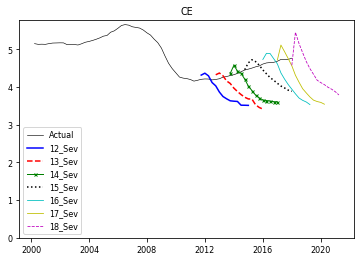

In [27]:
i = 0  ## enter 0, 1, or 2 only (for 3 items in svlst)
gr = pd.DataFrame(hsy[svlst[i]])
gr.rename(columns={svlst[i]:'Actual'},inplace=True)
cp3 = ccp[['yrscen','Date',svlst[i]]]
cp3 = cp3.pivot('Date','yrscen',svlst[i])

gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)
xa = list(gr3.index)

plt.rcParams.update({'font.size': 8})
plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
#plt.plot(xa, gr3['12_Bas'],c='b',ls=':',lw=1.3,label="12_Bas")
plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
#plt.plot(xa, gr3['13_Bas'],c='r',ls=':',lw=1.3,label="13_Bas")
plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
#plt.plot(xa, gr3['14_Bas'],c='g',ls=':',lw=1.3,label="14_Bas")
plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
#plt.plot(xa, gr3['15_Bas'],c='k',ls=':',lw=1.3,label="15_Bas")
plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
plt.title(svlst[i])
plt.ylim(ymin=0)
if svlst[i][0:2] == 'CE':
  lc = 3
else:
  lc = 2
plt.legend(loc=lc) # 2 (UE) or 3 (CE)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [28]:
svlst2 = svlst + ['UE']
svlst2.sort()
svlst2

['CE', 'CE_FLGA', 'UE', 'UE_FLGA']

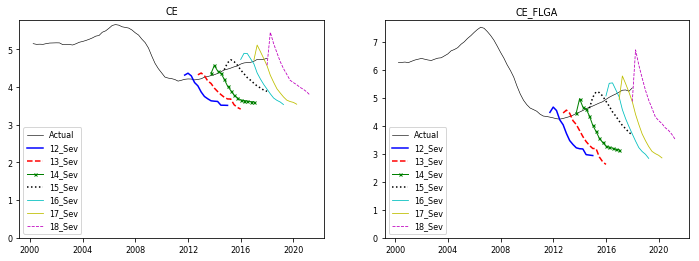

In [29]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=0  ## 0 or 2 only
for i in np.arange(2):
  plt.subplot(1, 2, i+1)
  gr = pd.DataFrame(hsy[svlst2[i+j]])
  gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
  cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
  cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

  gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

  plt.rcParams.update({'font.size': 8})
  plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
  plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
  plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
  plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
  plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
  plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
  plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
  plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
  plt.title(svlst2[i+j])
  plt.legend(loc=0)
  plt.ylim(ymin=0)

plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
plt.show()

In [30]:
"Var"+svlst2[i+j]+'_4var.png',

('VarCE_FLGA_4var.png',)

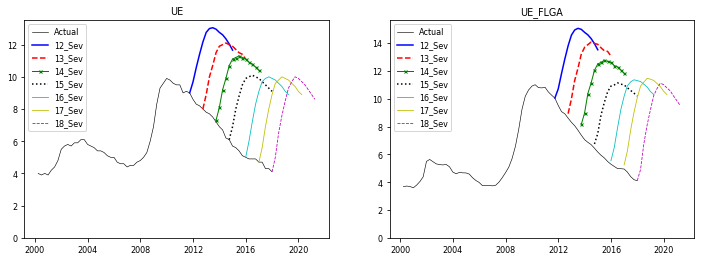

In [31]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=2  ## 0 or 2 only
if len(svlst2)==4:
  for i in np.arange(2):
    plt.subplot(1, 2, i+1)
    gr = pd.DataFrame(hsy[svlst2[i+j]])
    gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
    cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
    cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

    gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

    plt.rcParams.update({'font.size': 8})
    plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
    plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
    plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
    plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
    plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
    plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
    plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
    plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
    plt.title(svlst2[i+j])
    plt.legend(loc=0)
    plt.ylim(ymin=0)

if len(svlst2)== 4:
  plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('No output...')

In [32]:
stcol = [x for x in list(hs2.columns) if x not in list(hs.columns)]  ## list of new variables to process
stcol

['CE', 'CE_FLGA', 'UE_FLGA']

In [33]:
## add new state and CE columns to original history variable table ('hs'), call it hs3
if len(stcol)>0:
  hs3 = hs.copy()
  hs3.set_index('Date',drop=True,inplace=True)
  hs3 = hs3.ix['2000':]
  hs3 = hs3.merge(hs2[stcol],how='left',left_index=True,right_index=True)

hs3.head(2)

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
Date                                                                        
2000-03-31    1.2    4.3   8.1  11.8  4.0  4.0  5.5  6.6   6.7  8.2   8.3   
2000-06-30    7.8   10.2   4.2   6.1  3.9  3.2  5.7  6.5   6.4  8.5   8.3   

            Prime      DJ    HPI    CRE   VIX        CE   CE_FLGA   UE_FLGA  
Date                                                                         
2000-03-31    8.7  14.296  102.0  127.0  27.0  5.153778  6.264305  3.676629  
2000-06-30    9.2  13.619  105.0  125.0  33.5  5.135624  6.262501  3.721663

In [34]:
## add new state and CE columns to original ccar variable table ('cc'), call it cc3:
if len(stcol)>0:
  cc3 = cc.copy()
  cc3.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  cc3 = cc3.merge(ccs[['CCAR','Scen','Date']+stcol],how='left',on=['CCAR','Scen','Date'])

cc3.head(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...      \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0    ...       
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1    ...       

    BBB  Mort  Prime        DJ     HPI     CRE    VIX        CE   CE_FLGA  \
0  4.90  4.20    NaN  11.67700  132.00  177.00  48.00  4.318785  4.478057   
1  4.52  4.21    NaN  11.93609  137.21  172.17  35.97  4.310532  4.552453   

     UE_FLGA  
0  10.051433  
1  10.010235  

[2 rows x 22 columns]

In [35]:
hs3.to_csv(grp+'_histvars.csv')
cc3.to_csv(grp+'_ccarvars.csv')

In [36]:
## end of state variable (and CE) processing... move onto gathering bank data

In [37]:
## gather Call Rpt data for requested groups:

In [38]:
## process Call Rpt data for requested banks:
## rk table will be used to find identifiers (and associated acquired banks for BHCs)
if htyp == 'nohist':
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_nohist201806.csv", index_col=0)  # 201712 nohist version
else:
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201806.csv", index_col=0)  # 4/9/18: updated table 

rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
htyp

''

In [39]:
rk['C18'] = 'No'
rk['C31'] = 'No'
#c18tic
rk.loc[rk.Ticker.isin(c18tic), 'C18']='C18'
rk.loc[rk.Ticker.isin(c31tic), 'C31']='C31'

In [40]:
b18 = set(list(rk[rk['C18']=='C18']['IDRSSD']))  ## C18 banks 
b31 = set(list(rk[rk['C31']=='C31']['IDRSSD']))  ## C31 banks 

len(b18), len(b31), len(exlst) # 445, 608, 3

(445, 608, 3)

In [41]:
############ CAUTION
############ CAUTION

In [42]:
## CAUTION:  DO NOT RE-RUN THIS CELL if it was run earlier in session (wastes a lot of time)
## read Call Report extract file for all banks:
dg2 = pd.read_csv("df2_2001_201806.csv")
dg2['AsOf'] = pd.to_datetime(dg2['AsOf'])

fcol = dg2.columns[5:]  ## get listing of numeric fields, then...
dg2[fcol] = dg2[fcol].astype(float)  ### CRITICAL to convert numeric data to FLOAT!!! (since some are ints)

In [43]:
dcol = list(dg2)[5:]  ## data column names
dcol[0:5]

['Cert', 'eTotAst', 'eTotLn', 'eALLL', 'eOREO']

In [44]:
## grpTotUSx00:
px00 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px00 = dg2[['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px00n = dg2[['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px00n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px00 = pd.concat([px00n,px00], join='inner', axis=1)
  px00 = px00.reset_index(drop=False)
  px00['IDRSSD'] = 0
  px00['Grp'] = 'grp' + 'TotUS' + 'x00' + htyp
  px00 = px00[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px00)

70

In [45]:
## grpTotUSx18:
px18 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px18 = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px18n = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px18 = pd.concat([px18n,px18], join='inner', axis=1)
  px18 = px18.reset_index(drop=False)
  px18['IDRSSD'] = 0
  px18['Grp'] = 'grp' + 'TotUS' + 'x18' + htyp
  px18 = px18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px18)

70

In [46]:
## grpTotUSx31:
px31 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px31 = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px31n = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px31 = pd.concat([px31n,px31], join='inner', axis=1)
  px31 = px31.reset_index(drop=False)
  px31['IDRSSD'] = 0
  px31['Grp'] = 'grp' + 'TotUS' + 'x31' + htyp
  px31 = px31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px31)

70

In [47]:
#C18 processing:
pcx18=[]
if ('C18' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx18 = dg2[dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx18n = dg2[dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx18 = pd.concat([pcx18n,pcx18], join='inner', axis=1)
  pcx18 = pcx18.reset_index(drop=False)
  pcx18['IDRSSD'] = 0
  pcx18['Grp'] = 'grpC18x00'
  pcx18 = pcx18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx18)

0

In [48]:
# C31 processing:
pcx31=[]
if ('C31' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx31 = dg2[dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx31n = dg2[dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx31 =pd.concat([pcx31n,pcx31], join='inner', axis=1)
  pcx31 = pcx31.reset_index(drop=False)
  pcx31['IDRSSD'] = 0
  pcx31['Grp'] = 'grpC31x00'
  pcx31 = pcx31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx31)

0

In [49]:
## state level aggregates: # 20160414:  run x00
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
pxstx00 = []
if len(stlst)>0:
  xt = 'x00'
  stx = []
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  if len(stx)==0: strs = [x for x in strs]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx00 = pxst.copy()

len(pxstx00)

70

In [50]:
stlst

['FL', 'GA']

In [51]:
## state level aggregates: # 20160414:  run x18x
pxstx18x=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
if (len(stlst)>0)&(exflg=='x'):
  xt = 'x18'
  stx = list(b18) + exlst
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + exflg + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18x = pxst.copy()

len(pxstx18x)

70

In [52]:
## state level aggregates: # 20160414:  run x18
pxstx18=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
if (len(stlst)>0):
  xt = 'x18'
  stx = list(b18) 
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt  + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18 = pxst.copy()

len(pxstx18)

70

In [53]:
prd='eTotLn'
dgp5=[]

if len(stlst)>0:
  dgp = dg2[(dg2[prd]>0)&(dg2.State.isin(stlst))][['IDRSSD','Name','AsOf',prd]]
  dgp.sort_index(by=['IDRSSD',prd],ascending=[True,False],inplace=True)

  dgp.sort_index(by=['IDRSSD','AsOf'],inplace=True)
  dgp5 = dgp.ix[dgp.groupby(['IDRSSD']).apply(lambda x: x[prd].idxmax())]
  dgp5 = dgp5.merge(rk[['IDRSSD','Ticker','C18','C31','xState','xCert','xAsOf']],how='left',on='IDRSSD')
  dgp5.sort_index(by=[prd],ascending=False,inplace=True)
  dgp5.to_csv(grp+"_"+prd+"_maxbal.csv")

if len(dgp5)>20: dpg5=dgp5[0:20]
    
dgp5

IDRSSD                                         Name       AsOf  \
289   675332                                SUNTRUST BANK 2016-12-31   
544  2735146                                    TIAA, FSB 2017-12-31   
180   395238                                 SYNOVUS BANK 2018-06-30   
856  3938186                               BANKUNITED, NA 2018-06-30   
475  2193616                       RAYMOND JAMES BANK, NA 2018-06-30   
450  1442380                         UNIVERSAL BANK, N.A. 2001-09-30   
286   665931                           NORTHERN TRUST, NA 2010-12-31   
638  2962652                  BANK OF AMERICA GEORGIA, NA 2004-03-31   
340   814430                CITY NATIONAL BANK OF FLORIDA 2018-06-30   
418  1212846                    MONOGRAM CREDIT CARD BANK 2003-06-30   
858  4041421                   FLORIDA COMMUNITY BANK, NA 2018-06-30   
317   764030                                  AMERIS BANK 2018-06-30   
396  1017939                        UNITED COMMUNITY BANK 2018-06-30   
468  1929247                         CENTERSTATE BANK, NA 2018-06-30   
45     83638                           MERCANTIL BANK, NA 2018-06-30   
505  2578240                FIRST UNION DIRECT BANK, N.A. 2003-09-30   
859  4160667                     CAPITAL BANK CORPORATION 2015-12-31   
345   832377                        BANK OF NORTH GEORGIA 2008-12-31   
284   663834                                   OCEAN BANK 2006-06-30   
256   598534                                FIDELITY BANK 2018-06-30   
30     53033                     SABADELL UNITED BANK, NA 2017-03-31   
431  1396652                              MERCANTILE BANK 2007-06-30   
24     34537                       SEACOAST NATIONAL BANK 2018-06-30   
433  1401529               FIRST NATIONAL BANK OF FLORIDA 2004-12-31   
799  3536407                                  USAMERIBANK 2017-12-31   
752  3384318                 STATE BANK AND TRUST COMPANY 2018-03-31   
802  3550131                   WACHOVIA CARD SERVICES, NA 2009-12-31   
857  3967449                    COMMUNITY & SOUTHERN BANK 2015-12-31   
52    101233           RIVERSIDE NATIONAL BANK OF FLORIDA 2007-12-31   
533  2689463                          BB&T FINANCIAL, FSB 2012-12-31   
..       ...                                          ...        ...   
255   598132                     SECURITY STATE BANK, THE 2006-09-30   
709  3266487                    FLINT RIVER NATIONAL BANK 2008-06-30   
54    102333                        WILKINSON COUNTY BANK 2016-06-30   
259   610539                          BANK OF EDISON, THE 2016-09-30   
244   563934      FIRST NATIONAL BANK OF CHATTOOGA COUNTY 2005-06-30   
116   226734                           PEOPLES STATE BANK 2006-03-31   
44     83236                            BANK OF THE SOUTH 2018-06-30   
590  2845166                            BANCO POPULAR, NA 2003-06-30   
106   205430                                CITIZENS BANK 2003-12-31   
75    145835                      NET FIRST NATIONAL BANK 2001-09-30   
241   555836                    SYLVESTER BANKING COMPANY 2001-03-31   
337   808037                             PANAMERICAN BANK 2001-09-30   
25     34836                WOODBURY BANKING COMPANY, THE 2009-12-31   
855  3929812                  SILVERTON BRIDGE BANK, N.A. 2009-06-30   
265   615776  ELBERTON FEDERAL SAVINGS & LOAN ASSOCIATION 2017-09-30   
186   413570                         LIBERTY BANK & TRUST 2002-06-30   
374   959630                          BANK OF LUMBER CITY 2005-09-30   
12     14931                           FIRST WESTERN BANK 2003-03-31   
217   501039              GREENVILLE BANKING COMPANY, THE 2009-03-31   
281   649632                          ROCHELLE STATE BANK 2016-06-30   
624  2914820                           RBC BANK (GEORGIA) 2008-06-30   
576  2808723                           BELK NATIONAL BANK 2002-03-31   
390  1007734                      BARWICK BANKING COMPANY 2002-12-31   
473  2111508            SOUTHBANK, A FEDERAL S

In [54]:
# process requested tickers and IDRSSDs:
pxbk = []
if (len(tclst)>0)&(indiv=='Yes'):
  bkrs=rslst+list(rk[rk['Ticker'].isin(tclst)]['IDRSSD'])
  bknm=list(rk[rk['IDRSSD'].isin(bkrs)]['xName'])
  pxbk = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxbkn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxbkn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxbk =pd.concat([pxbkn,pxbk], join='inner', axis=1)
  pxbk = pxbk.reset_index(drop=False)
  pxbk['IDRSSD'] = 0
  pxbk['Grp'] = grp
  pxbk = pxbk[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pxbk), grp

(0, 'grpFLGAx18x')

In [55]:
# rslst processing:
pxri = []
if (len(rslst)>0)&(indiv=='Yes'):
  for i in np.arange(len(rslst)):
    bknm=rk[rk['IDRSSD']==rslst[i]]['xName']
    pxrj = dg2[dg2['IDRSSD']==rslst[i]][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxrjn = dg2[dg2['IDRSSD']==rslst[i]][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxrjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxrj = pd.concat([pxrjn,pxrj], join='inner', axis=1)
    pxrj = pxrj.reset_index(drop=False)
    pxrj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()]) + str(i)
    pxrj['IDRSSD'] = rslst[i]
    pxrj = pxrj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxri = pxrj.copy()
    else:
      pxri = pd.concat([pxri,pxrj],ignore_index=True)

len(pxri)

0

In [56]:
# tclst processing:  ## 20160505: handles multiple tickers in tclst!!
pxci = []
if (len(tclst)>0)&(indiv=='Yes'):
  # create dict for ParRSSD:
  tcd = dict([(i, x) for i, x in zip(rk[rk.Ticker.isin(tclst)].Ticker, rk.ParRSSD)])
  for i in np.arange(len(tclst)):
    bkrs=list(rk[rk['Ticker'].isin([tclst[i]])]['IDRSSD'])
    bknm=(rk[rk['IDRSSD']==bkrs[i]]['Parent'])
    pxcj = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxcjn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxcjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxcj = pd.concat([pxcjn,pxcj], join='inner', axis=1)
    pxcj = pxcj.reset_index(drop=False)
    pxcj['IDRSSD'] = tcd[tclst[i]]
    pxcj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()[0:3]]) + str(i)
    pxcj = pxcj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxci = pxcj.copy()
    else:
      pxci = pd.concat([pxci,pxcj],ignore_index=True)

len(pxci)

0

In [57]:
pxlst = [px00,px18,px31,pcx18,pcx31,pxstx00,pxstx18,pxstx18x,pxbk,pxri,pxci]
pxz = pd.concat([x for x in pxlst if len(x)>0])
gpxz = list(pxz[['Grp','AsOf']].groupby('Grp').count().index)
len(pxz), gpxz # 420, [list of groups]

(420,
 ['grpFLGAx00',
  'grpFLGAx18',
  'grpFLGAx18x',
  'grpTotUSx00',
  'grpTotUSx18',
  'grpTotUSx31'])

In [58]:
pxz[['Grp','nbr']].groupby('Grp').count()

nbr
Grp             
grpFLGAx00    70
grpFLGAx18    70
grpFLGAx18x   70
grpTotUSx00   70
grpTotUSx18   70
grpTotUSx31   70

In [59]:
pxz2 = pxz[['Grp','nbr']].groupby('Grp').mean()
pxz2

nbr
Grp                     
grpFLGAx00    499.314286
grpFLGAx18    482.642857
grpFLGAx18x   481.428571
grpTotUSx00  7367.042857
grpTotUSx18  7239.742857
grpTotUSx31  7179.200000

In [60]:
grplst = list(pxz2.index)
grplst

['grpFLGAx00',
 'grpFLGAx18',
 'grpFLGAx18x',
 'grpTotUSx00',
 'grpTotUSx18',
 'grpTotUSx31']

In [61]:
## set up processing tables for calcs:
df3 = pxz.copy()  # set up for calc processing using old table names
df3.sort_index(by=['Grp','IDRSSD','AsOf'],inplace=True)  ## added 12/24/15

df3['mn'] = df3['AsOf'].map(lambda x: x.month)  ## add separate month col to ease calcs converting YTDs to qtrly vals

df3a = df3[['Grp','IDRSSD','AsOf','mn']]  # table used to run calcs
df3z = df3[['Grp','IDRSSD','AsOf']]  # table to hold calc results

In [62]:
dct = { 3 : 0, 6 : 1/2 , 9 : 2/3, 12 : 3/4 }

# fn to adjust 1st row of each bank... 
# modified to use dict "dct" to speed processing:
def qa(x):
  if x['mn'] == 3: return 0
  if pd.isnull(x['x_1']):
    return dct[x['mn']] * x['x']
  else: 
    return x['x_1']

def q_calc(xi, xc):
  # calc Call Data into quarterly values from YTD values
  df3a['x'] = df3[xi]
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xi].shift(1)
  df3a['x_1'] = df3a.apply(qa, axis=1)
  df3a['xq'] = df3a['x'] - df3a['x_1']
  df3z[xc] = df3a['xq']
  return

In [63]:
q_calc('isNetInc', 'qNetInc')
q_calc('iiNetII', 'qNetII')
q_calc('isProv', 'qProv')
q_calc('isTotNII', 'qNonII')
q_calc('isTotNIE', 'qNonIE')
q_calc('isOREOgl', 'qOREOgl')    # 20160501
q_calc('isIntangExp', 'qIntangExp')

df3z['qRev'] = df3z['qNetII'] + df3z['qNonII']
df3z['qCashExp'] = df3z['qNonIE'] - df3z['qIntangExp']

q_calc('iiTotII', 'qiTotII')  # 20160320
q_calc('iiTotLn', 'qiTotLn')
q_calc('iiRE', 'qiRE')
q_calc('iiCI', 'qiCI')
q_calc('iiCard', 'qiCard')
q_calc('iiOthCsmr', 'qiOthCsmr')
q_calc('iiLeas','qiLeas')

df3z['qiTotLnLs'] = df3z['qiTotLn']+df3z['qiLeas']  #  20160320
df3z['qiOthLnLs'] = df3z['qiTotLnLs'] - df3z['qiRE'] - df3z['qiCI'] - df3z['qiCard'] - df3z['qiOthCsmr']  # 20160320

q_calc('iiDFIB', 'qiDFIB')
q_calc('iiTreas', 'qiTreas')
q_calc('iiMBS', 'qiMBS')
q_calc('iiOSec', 'qiOSec')
q_calc('iiFFS', 'qiFFS')
q_calc('iiOAstIB','qiOAstIB') # 20160320
q_calc('iiTotSec','qiTotSec') # 20160320
#df3z['qiTotSec'] = df3z['qiTreas'] + df3z['qiMBS'] + df3z['qiOSec']  # 20160320

q_calc('ieTotIE', 'qeTotIE') # 20160320
q_calc('ieNOW', 'qeNOW')
q_calc('ieSav', 'qeSav')
q_calc('ieCDun', 'qeCDun')
q_calc('ieCDov', 'qeCDov')
q_calc('ieFFP', 'qeFFP')
q_calc('ieFDepIB', 'qeFDepIB') ## 20160320
q_calc('ieDepIB', 'qeDepIB') ## 20160320

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ieOthBorr'] + df3['ieNote']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ieOthBorr'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ieNote'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qeBorr'] = df3a['xq']

q_calc('ieOLbIB','qeOLbIB') # 20160320

q_calc('ncoTotLn', 'qncTotLn')
q_calc('ncoCx', 'qncCx')
q_calc('ncoSfRev', 'qncSfRev')
q_calc('ncoSfTD', 'qncSfTD')
q_calc('ncoMult', 'qncMult')
q_calc('ncoCRE', 'qncCRE')
q_calc('ncoCIdom', 'qncCIdom')
q_calc('ncoCIfor', 'qncCIfor')
q_calc('ncoCard', 'qncCard')

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ncoAuto'] + df3['ncoOthCsmr']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ncoAuto'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ncoOthCsmr'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qncOthCsmr'] = df3a['xq']

df3z['qncCREtot'] = df3z['qncCx'] + df3z['qncMult'] + df3z['qncCRE']  # to match CCAR results categories
#df3['eCREtot'] = df3['eCx'] + df3['eMult'] + df3['eCRE']  # to match CCAR results categories

In [64]:
def y_calc(xn, xd, xc):  # quarterly yield calc (annualized):
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3z[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*400 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def r_calc(xn, xd, xc):  # rolling 4q yield calc:
  # calc rolling 4q items: yields, rates, nco rates
  df3a['x'] = df3z.groupby(['Grp','IDRSSD'])[xn].apply(lambda x:x.rolling(4, min_periods=4).sum())
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xd].apply(lambda x:x.rolling(4, min_periods=4).mean())
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def qn_calc(xn, xd, xc):  # quarterly non-accrual ratio calc:
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [65]:
y_calc('qNetII', 'aEarnAst', 'qyNetII') # 20160329
y_calc('qiTotII', 'aEarnAst', 'qyTotII') # 20160329
y_calc('qiTotLn', 'aTotLn', 'qyTotLn')
y_calc('qiRE', 'aTotRE', 'qyRE')
y_calc('qiCI', 'aCI', 'qyCI')
y_calc('qiCard', 'aCard', 'qyCard')
y_calc('qiOthCsmr', 'aOthCsmr', 'qyOthCsmr')
y_calc('qiOthLnLs','aOthLnLs','qyOthLnLs') # 20160320

y_calc('qiDFIB', 'aDFIB', 'qyDFIB')
y_calc('qiTreas', 'aTreas', 'qyTreas')
y_calc('qiMBS', 'aMBS', 'qyMBS')
y_calc('qiOSec', 'aOSec', 'qyOthSec')
y_calc('qiFFS', 'aFFS', 'qyFFS')
y_calc('qiOAstIB','aOAstIB','qyOAstIB') # 20160320
y_calc('qiTotLnLs', 'aTotLnLs', 'qyTotLnLs')
y_calc('qiTotSec', 'aTotSec', 'qyTotSec')
y_calc('qiOAstIB', 'aOAstIB', 'qyOAstIB')

y_calc('qeTotIE', 'aEarnAst', 'qrTotIE') # 20160329
y_calc('qeNOW', 'aNOW', 'qrNOW')
y_calc('qeSav', 'aSav', 'qrSav')
y_calc('qeCDun', 'aCDun', 'qrCDun')
y_calc('qeCDov', 'aCDov', 'qrCDov')
y_calc('qeFFP', 'aFFP', 'qrFFP')
y_calc('qeBorr', 'aBorr', 'qrBorr')
y_calc('qeOLbIB','aOLbIB','qrOLbIB') # 20160320)

y_calc('qeDepIB', 'aDepIB', 'qrDepIB')
y_calc('qeFDepIB','aFDepIB','qrFDepIB') # 20160320

r_calc('qncTotLn','eTotLn','rcTotLn')
r_calc('qncCx','eCx','rcCx')
r_calc('qncSfRev','eSfRev','rcSfRev')
r_calc('qncSfTD','eSfTD','rcSfTD')  # 6/10/15, uses new eSfTD item

r_calc('qncMult','eMult','rcMult')
r_calc('qncCRE','eCRE','rcCRE')
r_calc('qncCREtot','eCREtot','rcCREtot')
r_calc('qncCIdom','eCIdom','rcCIdom')
r_calc('qncCIfor','eCIfor','rcCIfor')
r_calc('qncCard','aCard','rcCard')
r_calc('qncOthCsmr','aOthCsmr','rcOthCsmr')  

y_calc('qncTotLn','eTotLn','qcTotLn')
y_calc('qncCx','eCx','qcCx')
y_calc('qncSfRev','eSfRev','qcSfRev')
y_calc('qncSfTD','eSfTD','qcSfTD')  # added 6/10/15

y_calc('qncMult','eMult','qcMult')
y_calc('qncCRE','eCRE','qcCRE')
y_calc('qncCREtot','eCREtot','qcCREtot')
y_calc('qncCIdom','eCIdom','qcCIdom')
y_calc('qncCIfor','eCIfor','qcCIfor')
y_calc('qncCard','aCard','qcCard')
y_calc('qncOthCsmr','aOthCsmr','qcOthCsmr')  

qn_calc('nTotLn','eTotLn','qnTotLn')
qn_calc('nCx','eCx','qnCx')
qn_calc('nSfRev','eSfRev','qnSfRev')
qn_calc('nSfTD','eSfTD','qnSfTD')  # added 6/10/15 using new eSfTD item

qn_calc('nMult','eMult','qnMult')
qn_calc('nCRE','eCRE','qnCRE')
qn_calc('nCIdom','eCIdom','qnCIdom')
qn_calc('nCIfor','eCIfor','qnCIfor')
qn_calc('nCard','aCard','qnCard')

df3a['x'] = df3['nOthCsmr'] + df3['nAuto']
df3a['x_1'] = df3['aOthCsmr']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['qnOthCsmr'] = df3a['xq']

In [66]:
def b_calc(xn, xd, xc):  # balance sheet ratio (no annualization factor)
  # calc balance sheet ratios:
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [67]:
##############################################
#
#  Final calcuations
#
##############################################
r_calc('qiTotII', 'aEarnAst', 'ryEA')
r_calc('qeTotIE', 'aEarnAst', 'rrIEEA')
r_calc('qNetII', 'aEarnAst', 'rNIM')
y_calc('qNetII', 'aEarnAst', 'qyNIM')

# special calcs for PPNR ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(lambda x:x.rolling(4, min_periods=4).sum()) -\
            df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(lambda x:x.rolling(4, min_periods=4).sum())
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['aTotAst'].apply(lambda x:x.rolling(4, min_periods=4).mean())
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rPPNR'] = df3a['xq']

r_calc('qNetInc', 'aTotAst', 'rROA')
r_calc('qNetInc', 'eTotEq', 'rROE')

# special calcs for Efficiency ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(lambda x:x.rolling(4, min_periods=4).sum()) 
df3a['x_1'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(lambda x:x.rolling(4, min_periods=4).sum())
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rEff'] = df3a['xq']

# loan-dep ratio:
df3a['x'] = df3['eTotLn']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eLn_Dep'] = df3a['xq']

# net fed funds to ast:
df3a['x'] = df3['aDFIB'] + df3['aFFS'] - df3['aFFP']
df3a['x_1'] = df3['aTotAst']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['aFF_TA'] = df3a['xq']

# brokered dep to dep:
df3a['x'] = df3['eBrok']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eBrok_Dep'] = df3a['xq']

# Tang equity to tang assets:
df3a['x'] = df3['eTotEq'] - df3['eGW'] - df3['OthIntang']
df3a['x_1'] = df3['eTotAst'] - df3['eGW'] - df3['OthIntang']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eTEq_TTA'] = df3a['xq']

#eT1Cap eTotRWA eT1rb
b_calc('eT1Cap', 'eTotRWA', 'eT1rb')
b_calc('eT1Cap', 'eTotAstLev', 'eT1lv')
b_calc('eTotCap', 'eTotRWA', 'eTotrb')
b_calc('eALLL', 'eTotLn', 'eALLL_Ln')
b_calc('eCx', 'eTotLn', 'mxCx')
b_calc('eSfFst', 'eTotLn', 'mxSfFst')
b_calc('eCRE', 'eTotLn', 'mxCRE')

# special code for CI (dom & foreign):
df3a['x'] = df3['eCIdom'] + df3['eCIfor']
df3a['x_1'] = df3['eTotLn']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['mxCI'] = df3a['xq']

b_calc('eCard', 'eTotLn', 'mxCard')
b_calc('eDDepNIB','eDDep','mxDDA')

df3z['eRWA_TA'] = df3.apply(lambda x: x['eTotRWA'] * 100 / max(x['eTotAst'],1), axis=1)
df3z['lnTotAst'] = np.log(df3['eTotAst'])

In [68]:
len(df3z)

420

In [69]:
## remove large negative chargeoff rates (rolling 4q):  (add this for all agg calcs!!!!!!!!!!!!!!!!!!!!)

zcol = list(df3z.columns.values)
rclst = [s for s in zcol if 'rc' == s[:2]]
#rclst

for r in rclst:
  df3z[r] = df3z.apply(lambda x: max(x[r], -.5), axis=1)

In [70]:
df3z.to_csv("df3z_"+grp+".csv") # save current qtr results

In [71]:
## merge df2 and df3z tables so that all calc data is together for charting and stress regressions and pd calcs:
df2_3z = pxz.merge(df3z[['Grp','IDRSSD','AsOf']+list(df3z.columns)[4:]],how='left',on=['Grp','IDRSSD','AsOf'])

In [72]:
df2_3z.to_csv("df2_3z_"+grp+".csv") # save current qtr results

In [73]:
"df2_3z_"+grp+".csv"

'df2_3z_grpFLGAx18x.csv'

In [74]:
rcc=['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr']  # loan cats
bcc = ['e' + x for x in rcc[0:7]]  # balance codes
bcc = bcc + ['a' + x for x in rcc[7:]] # NCO codes
ncc = ['rc'+x for x in rcc]
rcc, bcc, ncc

(['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr'],
 ['eTotLn',
  'eCx',
  'eSfRev',
  'eSfTD',
  'eMult',
  'eCRE',
  'eCIdom',
  'aCard',
  'aOthCsmr'],
 ['rcTotLn',
  'rcCx',
  'rcSfRev',
  'rcSfTD',
  'rcMult',
  'rcCRE',
  'rcCIdom',
  'rcCard',
  'rcOthCsmr'])

In [75]:
bdf = df2_3z[['Grp','AsOf']+bcc]
bdf2 = bdf.set_index(['Grp','AsOf'],drop=True)
bdf2.tail()

eTotLn         eCx     eSfRev       eSfTD  \
Grp         AsOf                                                         
grpFLGAx18x 2017-06-30  202981603.0  13732228.0  8042330.0  54945359.0   
            2017-09-30  200678195.0  13428304.0  8122231.0  53681054.0   
            2017-12-31  205854947.0  14055905.0  8333309.0  54894978.0   
            2018-03-31  202331284.0  13728232.0  8096196.0  53829291.0   
            2018-06-30  204847070.0  13701310.0  8160246.0  54147706.0   

                             eMult        eCRE      eCIdom     aCard  \
Grp         AsOf                                                       
grpFLGAx18x 2017-06-30  10712549.0  64980835.0  22134354.0  558621.0   
            2017-09-30   9981958.0  64155278.0  21818752.0  546511.0   
            2017-12-31   9631067.0  65220980.0  23057064.0  595504.0   
            2018-03-31   9527200.0  63879057.0  22771318.0  579223.0   
            2018-06-30   9375998.0  64381376.0  23595093.0  560183.0   

                         aOthCsmr  
Grp         AsOf                   
grpFLGAx18x 2017-06-30  6512764.0  
            2017-09-30  6737441.0  
            2017-12-31  7151698.0  
            2018-03-31  7364835.0  
            2018-06-30  7523123.0

In [76]:
## start stress mods...

In [77]:
## set up stress mod for stlst group starting here!
grplst

['grpFLGAx00',
 'grpFLGAx18',
 'grpFLGAx18x',
 'grpTotUSx00',
 'grpTotUSx18',
 'grpTotUSx31']

In [78]:
ndf = df2_3z[['Grp','AsOf']+ncc]
ndf2 = ndf.set_index(['Grp','AsOf'],drop=True)
#ndf3=ndf2.unstack(0)
ndf2.head()

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult  \
Grp         AsOf                                                           
grpTotUSx00 2001-03-31       NaN       NaN       NaN       NaN       NaN   
            2001-06-30       NaN       NaN       NaN       NaN       NaN   
            2001-09-30       NaN       NaN       NaN       NaN       NaN   
            2001-12-31  0.906950  0.128401  0.254723  0.198517  0.028189   
            2002-03-31  1.003935  0.140850  0.238045  0.206689  0.029043   

                           rcCRE   rcCIdom    rcCard  rcOthCsmr  
Grp         AsOf                                                 
grpTotUSx00 2001-03-31       NaN       NaN       NaN        NaN  
            2001-06-30       NaN       NaN       NaN        NaN  
            2001-09-30       NaN       NaN       NaN        NaN  
            2001-12-31  0.123373  1.712288  5.685286   1.381422  
            2002-03-31  0.139262  1.870484  6.531011   1.473849

In [79]:
bdz = bdf2.merge(ndf2,how='left',left_index=True, right_index=True)
bdz.head(2)

eTotLn          eCx       eSfRev        eSfTD  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  4.019129e+09  181944657.0  136326665.0  911174795.0   
            2001-06-30  4.052104e+09  192762892.0  141572092.0  925655130.0   

                             eMult         eCRE       eCIdom        aCard  \
Grp         AsOf                                                            
grpTotUSx00 2001-03-31  74421523.0  493334312.0  832079914.0  205311052.0   
            2001-06-30  74003767.0  502028474.0  812822577.0  205481263.0   

                           aOthCsmr  rcTotLn  rcCx  rcSfRev  rcSfTD  rcMult  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  359867608.0      NaN   NaN      NaN     NaN     NaN   
            2001-06-30  366821155.0      NaN   NaN      NaN     NaN     NaN   

                        rcCRE  rcCIdom  rcCard  rcOthCsmr  
Grp         AsOf                                           
grpTotUSx00 2001-03-31    NaN      NaN     NaN        NaN  
            2001-06-30    NaN      NaN     NaN        NaN

In [80]:
bdz2 = bdz.unstack(0)
bdz3=bdz2.swaplevel(0,1,axis=1)
bdz3.sort_index(axis=1,inplace=True)
bdz3.dropna(how='any',inplace=True)
bdz3.head(2)

Grp         grpFLGAx00                                                  \
                 aCard    aOthCsmr      eCIdom        eCRE         eCx   
AsOf                                                                     
2001-12-31  10283965.0  16373294.0  27853845.0  29572534.0  13413546.0   
2002-03-31   1645139.0  16840297.0  27853391.0  31162391.0  14002102.0   

Grp                                                                    ...     \
                eMult     eSfRev       eSfTD       eTotLn   rcCIdom    ...      
AsOf                                                                   ...      
2001-12-31  2480656.0  4812295.0  41026880.0  165156136.0  0.983608    ...      
2002-03-31  2642094.0  5850601.0  41771053.0  163249748.0  1.110066    ...      

Grp          grpTotUSx31                                                    \
                  eTotLn   rcCIdom     rcCRE    rcCard      rcCx    rcMult   
AsOf                                                                         
2001-12-31  1.175607e+09  1.792655  0.093605  8.040032  0.147851  0.020698   
2002-03-31  1.175559e+09  1.916935  0.102281  8.066209  0.166391  0.026414   

Grp                                                 
           rcOthCsmr   rcSfRev    rcSfTD   rcTotLn  
AsOf                                                
2001-12-31  0.984145  0.120721  0.076831  0.607571  
2002-03-31  1.006199  0.104805  0.080973  0.614697  

[2 rows x 108 columns]

In [81]:
ndf[['Grp','AsOf']].groupby('Grp').count()

AsOf
Grp              
grpFLGAx00     70
grpFLGAx18     70
grpFLGAx18x    70
grpTotUSx00    70
grpTotUSx18    70
grpTotUSx31    70

In [82]:
grp, grp[0:9]

('grpFLGAx18x', 'grpFLGAx1')

In [83]:
## CAUTION: Be sure that this x3lst has 3 entries with x00, x18, and x31 suffixes
##      If those do not exist, then set x3lst = []
## set-up charts for balhist and ncohist for x00, x18, x31 versions:
x3lst = []
if grp=='grpTotUSx00': x3lst = ['grpTotUSx00', 'grpC18x00', 'grpTotUSx18']
if grp=='grpTotUSx18': x3lst = ['grpTotUSx18', 'grpC18x00', 'grpTotUSx00']
if len(stlst)>0: x3lst = [grp] + ['grp'+''.join(stlst)+'x00'] + ['grp'+''.join(stlst)+'x18']
if grp[0:9]=='grpCapFid': x3lst = [grp] + ['grpFLGAx18x','grpFLGAx00']
x3lst, len(x3lst)

(['grpFLGAx18x', 'grpFLGAx00', 'grpFLGAx18'], 3)

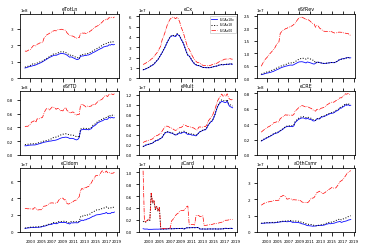

In [84]:
# assumes x18 is second grp, x00 is 1st grp, x31 is third grp:
if len(x3lst) == 3:
  xb = list(bdz3.index)
  plt.rcParams.update({'font.size': 4})

  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
    plt.plot(xb, bdz3[x3lst[2],bcc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
    plt.plot(xb, bdz3[x3lst[1],bcc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
    plt.ylim(ymin=0)
    plt.title(bcc[i],y=.97)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
    if i==1: lg = plt.legend(loc=0, fontsize=3)

    if i < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      labelbottom=labl) # labels along the bottom edge are off

  plt.savefig(grp+'_balhist3.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('skip this section')

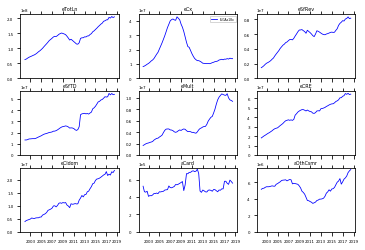

In [85]:
xb = list(bdz3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
  plt.ylim(ymin=0)
  plt.title(bcc[i],y=.97)
  plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
  if i==1: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_balhist1.png', dpi=400, bbox_inches='tight')
plt.show()

In [86]:
bdz3.head(2)

Grp         grpFLGAx00                                                  \
                 aCard    aOthCsmr      eCIdom        eCRE         eCx   
AsOf                                                                     
2001-12-31  10283965.0  16373294.0  27853845.0  29572534.0  13413546.0   
2002-03-31   1645139.0  16840297.0  27853391.0  31162391.0  14002102.0   

Grp                                                                    ...     \
                eMult     eSfRev       eSfTD       eTotLn   rcCIdom    ...      
AsOf                                                                   ...      
2001-12-31  2480656.0  4812295.0  41026880.0  165156136.0  0.983608    ...      
2002-03-31  2642094.0  5850601.0  41771053.0  163249748.0  1.110066    ...      

Grp          grpTotUSx31                                                    \
                  eTotLn   rcCIdom     rcCRE    rcCard      rcCx    rcMult   
AsOf                                                                         
2001-12-31  1.175607e+09  1.792655  0.093605  8.040032  0.147851  0.020698   
2002-03-31  1.175559e+09  1.916935  0.102281  8.066209  0.166391  0.026414   

Grp                                                 
           rcOthCsmr   rcSfRev    rcSfTD   rcTotLn  
AsOf                                                
2001-12-31  0.984145  0.120721  0.076831  0.607571  
2002-03-31  1.006199  0.104805  0.080973  0.614697  

[2 rows x 108 columns]

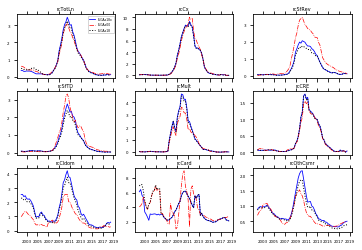

In [87]:
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],ncc[i]],c='b',lw=0.8,label=x3lst[0][3:])
  if len(x3lst)>1: plt.plot(xb, bdz3[x3lst[1],ncc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
  if len(x3lst)>2: plt.plot(xb, bdz3[x3lst[2],ncc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
  plt.title(ncc[i],y=.97)
  if i==0: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_ncohist.png', dpi=400, bbox_inches='tight')
plt.show()

In [88]:
## sections to build stress models for main group: var data in 'hs3' and 'cc3'

In [89]:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

rclst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
qclst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']

if qtyp == 1:
  curlst = qclst
elif qtyp == 4:
  curlst = rclst
else:
  curlst = []  # force error if qtyp not 1 or 4

#cbon = vtyp

In [90]:
dfc = df2_3z[df2_3z['Grp']==grp]  #  only copy requested groups in "grp"
dfc.dropna(axis=0, how='any', inplace=True)
dfc.head(2)

AsOf          Grp  IDRSSD  nbr        Cert     eTotAst      eTotLn  \
353 2001-12-31  grpFLGAx18x       0  541  12957613.0  94133981.0  62379658.0   
354 2002-03-31  grpFLGAx18x       0  541  13085221.0  97183964.0  64114964.0   

        eALLL     eOREO       eGW    ...         eTotrb  eALLL_Ln       mxCx  \
353  875978.0  145603.0  420763.0    ...      14.729613  1.404269  13.120611   
354  904471.0  144387.0  403895.0    ...      14.774163  1.410702  13.359686   

       mxSfFst      mxCRE     mxCI    mxCard      mxDDA    eRWA_TA   lnTotAst  
353  20.157663  28.990807  7.19936  0.792630  15.461892  72.294520  18.360230  
354  19.521508  29.777813  7.80143  0.726205  15.437980  71.960522  18.392116  

[2 rows x 322 columns]

In [91]:
## sUE_CA2 processing
st=''.join(stlst)
hs3.reset_index(drop=False,inplace=True)
hs3.head(2)

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
0 2000-03-31    1.2    4.3   8.1  11.8  4.0  4.0  5.5  6.6   6.7  8.2   8.3   
1 2000-06-30    7.8   10.2   4.2   6.1  3.9  3.2  5.7  6.5   6.4  8.5   8.3   

   Prime      DJ    HPI    CRE   VIX        CE   CE_FLGA   UE_FLGA  
0    8.7  14.296  102.0  127.0  27.0  5.153778  6.264305  3.676629  
1    9.2  13.619  105.0  125.0  33.5  5.135624  6.262501  3.721663

In [92]:
## parameters for sUE calcs below (by specified CCAR year):
uex = hs3[['Date','UE']].ix[hs3['UE'].idxmax()]
ccp = cc3[['CCAR','Scen','Date','UE']].iloc[cc3.groupby(['CCAR']).apply(lambda x: x['UE'].idxmax())]

def qtn(d):
  return 4*(d.year - 2000) + d.quarter

uex['qtn'] = qtn(uex['Date'])
ccp['qtn'] = ccp.apply(lambda x: qtn(x['Date']), axis=1)

uep = uex['UE']
ccp['adz'] = uep / ccp['UE']
ccp['que'] = uex['qtn']
ccp['pdt'] = uex['Date']


In [93]:
ccps = []

## parameters for sUE_st calcs below (by specified CCAR year):
if len(stlst)>0:
  UE_st = 'UE_'+''.join(stlst)
  uexs = hs3[['Date',UE_st]].ix[hs3[UE_st].idxmax()]
  ccps = cc3[['CCAR','Scen','Date',UE_st]].iloc[cc3.groupby(['CCAR']).apply(lambda x: x[UE_st].idxmax())]

  uexs['qtn'] = qtn(uexs['Date'])
  ccps['qtn'] = ccps.apply(lambda x: qtn(x['Date']), axis=1)

  ueps = uexs[UE_st]
  ccps['adz'] = ueps / ccps[UE_st]
  ccps['que'] = uexs['qtn']
  ccps['pdt'] = uexs['Date']


In [94]:
ccps

CCAR Scen       Date    UE_FLGA  qtn       adz  que        pdt
21   2012  Sev 2013-06-30  15.059377   54  0.730817   41 2010-03-31
63   2013  Sev 2014-06-30  14.074333   58  0.781966   41 2010-03-31
105  2014  Sev 2015-06-30  12.767286   62  0.862020   41 2010-03-31
147  2015  Sev 2016-06-30  11.138668   66  0.988058   41 2010-03-31
189  2016  Sev 2017-09-30  11.359290   71  0.968868   41 2010-03-31
231  2017  Sev 2018-09-30  11.463087   75  0.960095   41 2010-03-31
273  2018  Sev 2019-09-30  11.115267   79  0.990138   41 2010-03-31

In [95]:
ccp

CCAR Scen       Date     UE  qtn       adz  que        pdt
21   2012  Sev 2013-06-30  13.05   54  0.758621   40 2009-12-31
63   2013  Sev 2014-06-30  12.10   58  0.818182   40 2009-12-31
105  2014  Sev 2015-06-30  11.30   62  0.876106   40 2009-12-31
147  2015  Sev 2016-06-30  10.10   66  0.980198   40 2009-12-31
189  2016  Sev 2017-09-30  10.00   71  0.990000   40 2009-12-31
231  2017  Sev 2018-09-30  10.00   75  0.990000   40 2009-12-31
273  2018  Sev 2019-09-30  10.00   79  0.990000   40 2009-12-31

In [96]:
##########################################################################################
# Date selection for desired CCAR year:
# note:  CCAR 2013 implies stress period (9q) of 2012Q4 thru 2014Q4 (altho' scenario data goes thru 2015Q4)
##########################################################################################

ccar = 2018

if ccar <= 2015:
  dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
else:
  dtend = pd.to_datetime(str(ccar-1) + '-12-31')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+3) + '-03-31')  # end date for CCAR forecast (13-qtr end date)

dtend, frend

(Timestamp('2017-12-31 00:00:00'), Timestamp('2021-03-31 00:00:00'))

In [97]:
## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
ccx = cc3[cc3['CCAR'] == ccar]  # ccx contains forecast periods for selected CCAR start year
ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)  ## remove var if not included in CCAR list for this year

hsx = hs3.copy()  ## historical macrovars for this run
hsx.tail(5)

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
67 2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4  1.7   2.2  4.1   3.8   
68 2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6  2.0   2.5  4.2   4.2   
69 2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9  1.8   2.3  4.0   4.0   
70 2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0  1.8   2.3  3.9   3.9   
71 2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2  2.1   2.4  4.0   3.9   

    Prime      DJ    HPI    CRE   VIX        CE   CE_FLGA   UE_FLGA  
67    3.5  23.277  184.0  269.0  22.5  4.685861  5.200548  4.944684  
68    3.8  24.508  187.0  262.0  13.1  4.733969  5.268938  4.722285  
69    4.0  25.125  190.0  272.0  16.0  4.733918  5.277976  4.400068  
70    4.3  26.149  193.0  275.0  16.0  4.735612  5.233066  4.178191  
71    4.3  27.673  194.0  279.0  13.1  4.768160  5.352447  4.100611

In [98]:
if vtyp==2:  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccp[ccp['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccp[ccp['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccp[ccp['CCAR']==ccar]['Date'])
  ueinc = (1 - ccp[ccp['CCAR']==ccar]['adz']) / (ccp[ccp['CCAR']==ccar]['qtn'] - ccp[ccp['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE'] = ccx['UE'] * ccx['uead']
  ccx['sUE2'] = ccx['sUE']**2
  if '3' in styp: ccx['sUE3'] = ccx['sUE']**3
  ccx.drop(['uead','sUE'],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE'] = hsx['UE'] * hsx['uead']
  hsx['sUE2'] = hsx['sUE'] ** 2
  if '3' in styp: hsx['sUE3'] = hsx['sUE'] ** 3
  hsx.drop(['uead','sUE'],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...      \
40  2018  Sev 2020-12-31    4.5    5.5   3.1   4.3  8.9  1.6  0.1    ...       
41  2018  Sev 2021-03-31    4.5    5.4   3.3   4.5  8.6  1.5  0.1    ...       

    Mort  Prime      DJ    HPI    CRE   VIX        CE   CE_FLGA   UE_FLGA  \
40   4.9    3.2  18.143  141.0  176.0  15.0  3.876559  3.693807  9.857733   
41   4.7    3.2  20.168  143.0  180.0  14.4  3.791752  3.518182  9.524021   

         sUE2  
40  77.915476  
41  72.751277  

[2 rows x 23 columns]

In [99]:
## sUE_st2 & sUE_st3 vars:
if (vtyp==2)&(len(stlst)>0):  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccps[ccps['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccps[ccps['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccps[ccps['CCAR']==ccar]['Date'])
  ueinc = (1 - ccps[ccps['CCAR']==ccar]['adz']) / (ccps[ccps['CCAR']==ccar]['qtn'] - ccps[ccps['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE_'+''.join(stlst)] = ccx[UE_st] * ccx['uead']
  ccx['sUE_'+''.join(stlst)+'2'] = ccx['sUE_'+''.join(stlst)]**2
  if '3' in styp: ccx['sUE_'+''.join(stlst)+'3'] = ccx['sUE_'+''.join(stlst)]**3
  ccx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE_'+''.join(stlst)] = hsx['UE_'+''.join(stlst)] * hsx['uead']
  hsx['sUE_'+''.join(stlst)+'2'] = hsx['sUE_'+''.join(stlst)] ** 2
  if '3' in styp: hsx['sUE_'+''.join(stlst)+'3'] = hsx['sUE_'+''.join(stlst)] ** 3
  hsx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...      \
40  2018  Sev 2020-12-31    4.5    5.5   3.1   4.3  8.9  1.6  0.1    ...       
41  2018  Sev 2021-03-31    4.5    5.4   3.3   4.5  8.6  1.5  0.1    ...       

    Prime      DJ    HPI    CRE   VIX        CE   CE_FLGA   UE_FLGA  \
40    3.2  18.143  141.0  176.0  15.0  3.876559  3.693807  9.857733   
41    3.2  20.168  143.0  180.0  14.4  3.791752  3.518182  9.524021   

         sUE2  sUE_FLGA2  
40  77.915476  95.617650  
41  72.751277  89.253388  

[2 rows x 24 columns]

In [100]:
## history vars: lag (4q) vars for UE, HPI, CRE:
if vtyp > 0:
  hsx['UE_4'] = hsx['UE'].shift(4)  ## add 4q lag version of UE
  hsx['HPI_4'] = hsx['HPI'].shift(4)
  hsx['CRE_4'] = hsx['CRE'].shift(4)
  hsx['CE_4'] = hsx['CE'].shift(4)

  ccx[['UE_4','HPI_4','CRE_4','CE_4']] = ccx[['UE','HPI','CRE','CE']].shift(4)
  if ccar <= 2015:
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-09-30',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-2)+'-12-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-03-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-06-30',['UE','HPI','CRE','CE']].values
  if ccar >= 2016:
    ccx.ix[ccx.Date==str(ccar)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['UE','HPI','CRE','CE']].values

  if len(stlst)>0: 
    hsx[UE_st +'_4'] = hsx[UE_st].shift(4)  ## add 4q lag version of UE
    hsx['CE_'+''.join(stlst) +'_4'] = hsx['CE_'+''.join(stlst)].shift(4)  ## add 4q lag version of UE
    ccx[UE_st+'_4'] = ccx[UE_st].shift(4)
    ccx['CE_'+''.join(stlst) +'_4'] = ccx['CE_'+''.join(stlst)].shift(4)
    if ccar <= 2015:
      ccx.ix[ccx.Date==str(ccar-1)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
            hsx.ix[hsx.Date==str(ccar-2)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-12-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-03-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-03-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-06-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-06-30',[UE_st,'CE_'+''.join(stlst)]].values
    if ccar >= 2016:
      ccx.ix[ccx.Date==str(ccar)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
            hsx.ix[hsx.Date==str(ccar-1)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values

  ## double check CE, cest, uest vars on boundary date bet hist and forecast (9/30/ccyr-1)
  if ccar <= 2015:
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['CE']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['CE']].values
  else:
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['CE']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-12-31',['CE']].values

#hsx.dropna(how='any', inplace=True)
hsx.tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y    ...      \
67 2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4  1.7   2.2    ...       
68 2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6  2.0   2.5    ...       
69 2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9  1.8   2.3    ...       
70 2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0  1.8   2.3    ...       
71 2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2  2.1   2.4    ...       

     CE_FLGA   UE_FLGA       sUE2  sUE_FLGA2  UE_4  HPI_4  CRE_4      CE_4  \
67  5.200548  4.944684  21.773949  24.108468   5.0  175.0  254.0  4.611863   
68  5.268938  4.722285  21.762703  21.977069   4.9  177.0  245.0  4.641711   
69  5.277976  4.400068  18.206633  19.070279   4.9  179.0  248.0  4.651120   
70  5.233066  4.178191  18.197225  17.186516   4.9  182.0  266.0  4.658030   
71  5.352447  4.100611  16.535275  16.545546   4.7  184.0  269.0  4.685861   

    UE_FLGA_4  CE_FLGA_4  
67   5.288421   4.940047  
68   5.133147   5.016756  
69   4.977891   5.078959  
70   4.966883   5.134614  
71   4.944684   5.200548  

[5 rows x 28 columns]

In [101]:
ccs = ccx.copy()  # CCAR scenarios for selected year
cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
if 'No' in irflg:
  cccol = [x for x in cccol if x not in xvr] 

Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables

hsx = hsx[['Date']+cccol]  ## align var columns between hist and ccar lists (& remove forecast rows)
hsz = hsx[hsx['Date']<=frend].merge(dfc[['Grp','IDRSSD','AsOf']+curlst],\
                                    how='left',left_on='Date',right_on='AsOf') # merge hs and df data
### remove any rows with missing data:
hsz.dropna(how='any',inplace=True)
hsy = hsz[hsz['Date']<=dtend]  # cut off table at end of history: (ccar_yr-1)-09-30... use this to build models

ccs['Intercept'] = 1.0  # to set up fitting model

hsz['Intercept'] = 1.0   # to set up fitting for all available history

In [102]:
#######################################################
# 12/13/15: added new code for "big3" variables:
#######################################################
cccol3 = []
if ('Big' in irflg)|('big' in irflg):
  for i in np.arange(len(big3)):
    cccol3 = cccol3 + [x for x in cccol if big3[i] in x]
  cccol = cccol3
  Xcol = ['Intercept'] + cccol

cccol = [x for x in cccol if x[-1]!='3']
Xcol = [x for x in Xcol if x[-1]!='3']
Xcol

['Intercept',
 'rGDPg',
 'nGDPg',
 'rDIg',
 'nDIg',
 'UE',
 'CPI',
 'DJ',
 'HPI',
 'CRE',
 'VIX',
 'CE',
 'CE_FLGA',
 'UE_FLGA',
 'sUE2',
 'sUE_FLGA2',
 'UE_4',
 'HPI_4',
 'CRE_4',
 'CE_4',
 'UE_FLGA_4',
 'CE_FLGA_4']

In [103]:
## model:  du003edb...
## start full model here:

In [104]:
# start full model loop here:
for rc in curlst:
  eqn = rc + " ~ " + " + ".join(cccol)
  yt, Xt = dmatrices(eqn , data=hsy, return_type='dataframe')
  mod = sm.OLS(yt, Xt)
  res_tot = mod.fit()
  pred_tot = res_tot.predict(Xt)
  p_tot = res_tot.predict(ccs[Xcol])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt.rename(columns = {rc : 'Actual'}, inplace=True)
  frt['Fit'] = res_tot.predict(hsz[Xcol])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.rename(columns = {'pred' : 'Base'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'Adverse'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'SevAdv'}, inplace=True)
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()
  frt2.columns = [[rc]*len(frt.columns),frt.columns]

  prm = res_tot.params
  prm['rsq'] = res_tot.rsquared
  prm2 = pd.DataFrame(prm)
  prm2.columns = [rc]

  if rc == curlst[0]:
    frt3 = frt2.copy()
    prm3 = prm2.copy()
  else:
    frt3 = frt3.merge(frt2, how='left', left_index=True, right_index=True)
    prm3 = prm3.merge(prm2, how='left', left_index=True, right_index=True)


In [105]:
frt3.to_csv(grp + "_" + str(ccar) + "_full_fcst_" + str(qtyp) + "q_" + styp + irflg + ".csv")
prm3.to_csv(grp + "_" + str(ccar) + "_full_param_" + str(qtyp) + "q_" + styp + irflg + ".csv")
ccar, grp, styp, irflg

(2018, 'grpFLGAx18x', 'Lags_sUE2', '_NoRates')

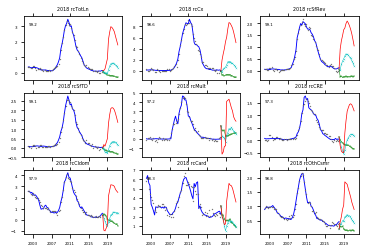

In [106]:
xax = list(frt3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
  plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
  plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.5,mew=.25,c='c')
  plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=.7)
  plt.title(str(ccar)+" "+curlst[i])
  plt.annotate(str(round(prm3.ix['rsq'][curlst[i]]*100,1)), xy=(0.05, 0.86), xycoords='axes fraction', fontsize=4)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+"_"+str(ccar)+'_full'+str(qtyp) + "q_"+styp+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [107]:
prm3

rcTotLn       rcCx   rcSfRev    rcSfTD     rcMult     rcCRE  \
Intercept -3.478236  18.572538 -2.492268 -2.330244 -17.720494 -0.953735   
rGDPg     -0.020592  -0.121606 -0.031015 -0.006851   0.068587 -0.036791   
nGDPg      0.016534   0.041266  0.016416  0.015567  -0.060074  0.024245   
rDIg      -0.009465   0.097739 -0.019921 -0.028673  -0.155521  0.010682   
nDIg       0.009805  -0.119639  0.019027  0.028309   0.163939 -0.012376   
UE         0.147572  -2.340770 -0.486460 -0.469026   0.531645 -0.791090   
CPI       -0.009059   0.088377 -0.024943 -0.016073  -0.097869 -0.002851   
DJ         0.017729  -0.076365 -0.022051  0.017847   0.028707  0.007906   
HPI       -0.006672  -0.023278 -0.003556 -0.005302   0.023048 -0.001097   
CRE        0.002541   0.006630  0.001221  0.000728   0.006361  0.001814   
VIX        0.002362  -0.005897 -0.002722  0.005181   0.006726 -0.003169   
CE         0.394323   1.901899  0.936118  0.182599   2.931502  0.554293   
CE_FLGA   -0.008276  -0.158016 -0.080733  0.197460  -2.501566 -0.217252   
UE_FLGA   -0.689388  -0.156612  0.322994 -0.208295  -0.905328  0.196821   
sUE2      -0.028818   0.170258  0.044377  0.012672  -0.060217  0.046478   
sUE_FLGA2  0.084157   0.081981 -0.008027  0.046260   0.112451 -0.000002   
UE_4       0.130836   0.187184  0.002993  0.197277   0.624851  0.013701   
HPI_4     -0.010106  -0.005208 -0.002301 -0.006292  -0.040702 -0.004584   
CRE_4      0.004924   0.018742  0.007491  0.004804   0.007053 -0.001877   
CE_4       0.513821  -8.528095 -0.919779  0.201167   2.440481  0.014664   
UE_FLGA_4  0.073833   0.179195  0.100897  0.050859  -0.381180  0.191434   
CE_FLGA_4  0.047723   3.533563  0.339900  0.042715   0.744715  0.193929   
rsq        0.992267   0.985665  0.991333  0.990611   0.971815  0.973127   

            rcCIdom     rcCard  rcOthCsmr  rcCREtot  
Intercept -0.466867  23.520519  -5.372056 -4.064990  
rGDPg     -0.010881  -0.331082  -0.008182 -0.031932  
nGDPg      0.032686   0.198293   0.018035  0.014148  
rDIg       0.050296   0.214327  -0.025072 -0.011501  
nDIg      -0.043412  -0.177698   0.030874  0.009216  
UE         1.579537  -6.987093   0.266373  0.084289  
CPI        0.014105   0.042302  -0.023489 -0.006951  
DJ         0.096458  -0.085851   0.033703  0.002334  
HPI       -0.011073   0.032375  -0.006518 -0.004623  
CRE       -0.005768  -0.001705  -0.000668  0.004397  
VIX        0.008464  -0.040949   0.005338 -0.000169  
CE        -0.430480   3.705939  -0.529239  0.826252  
CE_FLGA    0.083564  -1.494334   0.433279 -0.274628  
UE_FLGA   -2.062814   3.934578  -0.261269 -0.722340  
sUE2      -0.149110   0.395505  -0.006595 -0.026126  
sUE_FLGA2  0.178085  -0.151068   0.020439  0.095157  
UE_4      -0.445983  -0.642864   0.146866  0.221608  
HPI_4     -0.023183  -0.092223  -0.007888 -0.011148  
CRE_4     -0.000327   0.015601   0.005775  0.005476  
CE_4       1.844711  -6.833751   1.807892  0.180705  
UE_FLGA_4  0.516830   0.431632  -0.052329  0.024641  
CE_FLGA_4  0.044858   3.999896  -0.561761  0.241773  
rsq        0.978555   0.883454   0.987601  0.991012

In [108]:
### build 3-var models:

In [109]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [110]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [111]:
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))

In [112]:
### sections to generate forecasts for all 3-var models:

for idx, row in df3b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] # use this if using top3_rc

  if x == 0:
    frt3b = frt2.copy()
  else:
    frt3b = frt3b.merge(frt2, how='outer', left_index=True, right_index=True)

In [113]:
frt3s = pd.DataFrame(frt3b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt3s.reset_index(drop=False, inplace=True)
frt3s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt3s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
#frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn + 1
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv.head(8)

scen        rc    Actual   Adverse       Base       Fit     SevAdv      rc2  \
0     rcTotLn0  0.130669  4.668375  -0.239177  0.003027  15.774007  rcTotLn   
1     rcTotLn1  0.130669  4.758256   1.521460  0.108470  16.286670  rcTotLn   
2     rcTotLn2  0.130669  4.763286  -1.504812 -0.052230  16.236874  rcTotLn   
3        rcCx0 -0.014052  8.854713  -2.943307 -0.192620  37.901016     rcCx   
4        rcCx1 -0.014052  9.459644  -1.165187  0.013444  38.034593     rcCx   
5        rcCx2 -0.014052  7.833084 -12.757300 -1.034277  36.398701     rcCx   
6     rcSfRev0  0.120454  6.707879  -0.947309 -0.100369  13.650922  rcSfRev   
7     rcSfRev1  0.120454  5.927926  -1.579833 -0.096417  12.970342  rcSfRev   

scen  ord       diff  rk  
0       0  15.774007   1  
1       0  16.286670   2  
2       0  16.236874   3  
3       1  37.901016   1  
4       1  38.034593   2  
5       1  36.398701   3  
6       2  13.650922   1  
7       2  12.970342   2

In [114]:
df3bc = df3b.copy()
df3bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df3bc['rc'] = df3bc.index % topn
df3bc['rc'] = df3bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df3bc = df3bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df3bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df3bc.reset_index(drop=True, inplace=True)
df3bc.index.names = [grp+"_"+str(ccar)+"_"+styp]
df3bc.tail()

rc2         v1        r1         v2  \
grpFLGAx18x_2018_Lags_sUE2                                              
25                          rcOthCsmr       sUE2  0.628654  UE_FLGA_4   
26                          rcOthCsmr       sUE2  0.628654       CE_4   
27                           rcCREtot  sUE_FLGA2  0.953528  CE_FLGA_4   
28                           rcCREtot  sUE_FLGA2  0.953528    UE_FLGA   
29                           rcCREtot  sUE_FLGA2  0.953528  CE_FLGA_4   

                                  r2     v3        r3       Int        c1  \
grpFLGAx18x_2018_Lags_sUE2                                                  
25                          0.927499     DJ  0.937488  0.880128  0.025934   
26                          0.909167   UE_4  0.933159 -1.234058  0.023585   
27                          0.970172     UE  0.979380 -0.522267  0.055844   
28                          0.973870  rGDPg  0.978676  1.595883  0.082744   
29                          0.970172    HPI  0.978245 -3.090267  0.041942   

                                  c2        c3          rc  ord  rk  
grpFLGAx18x_2018_Lags_sUE2                                           
25                         -0.150909 -0.012779  rcOthCsmr1    8   2  
26                          0.347084 -0.099107  rcOthCsmr2    8   3  
27                          0.174820 -0.337744   rcCREtot0    9   1  
28                         -0.690851 -0.039452   rcCREtot1    9   2  
29                          0.181828  0.006577   rcCREtot2    9   3

In [115]:
frt3b.to_csv(grp + "_"  + str(ccar) +'_3v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df3bc.to_csv(grp + "_"  + str(ccar) + '_3v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2018

In [116]:
rnk = 1  ## 1 to topn

df_bst = df3bc[df3bc['rk']== rnk][['rc','v1','v2','v3','r3']]
df_bst.dropna(how='any', inplace=True)
df_bst.reset_index(drop=True, inplace=True)

def vlst(x):
  lst = [x['v1'],x['v2'],x['v3'],str(round(x['r3']*100,1))]
  return ';'.join(lst)

df_bst['var'] = df_bst.apply(vlst, axis=1)
dflst = list(df_bst['var'])
#dflst2 = [dflst[i] for i in grord]
dflst

['sUE_FLGA2;UE_FLGA;CE_FLGA_4;98.2',
 'sUE_FLGA2;UE_FLGA;UE_4;96.1',
 'UE_FLGA;HPI_4;CRE;97.7',
 'sUE_FLGA2;UE_FLGA;UE_4;97.0',
 'sUE_FLGA2;CE_4;CRE_4;94.7',
 'sUE_FLGA2;UE_FLGA_4;CE_FLGA_4;95.0',
 'CRE;sUE_FLGA2;UE;92.7',
 'sUE2;CRE;sUE_FLGA2;74.4',
 'sUE2;UE_FLGA_4;CRE;93.8',
 'sUE_FLGA2;CE_FLGA_4;UE;97.9']

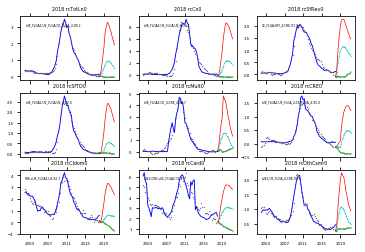

In [117]:
plt.rcParams.update({'font.size': 4})

#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='+',mew=.25,ms=1.2,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [118]:
grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png'

'grpFLGAx18x_2018_4q_3v9n_Lags_sUE2_3rk1_NoRates.png'

In [119]:
frt3b.ix[:'2012-09-30'][df_bst.ix[i]['rc'],'Actual'][-4:]

Date
2011-12-31    1.000992
2012-03-31    0.963569
2012-06-30    0.865471
2012-09-30    0.741355
Name: (rcOthCsmr0, Actual), dtype: float64

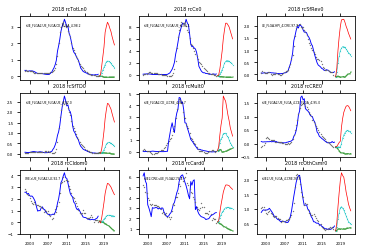

In [120]:
# alt version cuts off act and fit before 1st CCAR forecast period
plt.rcParams.update({'font.size': 4})
xaz=list(frt3b.ix[:str(ccar-1)+'-09-30'].index)
#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='+',mew=.25,ms=1.2,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'alt.png', dpi=400, bbox_inches='tight')
plt.show()

In [121]:
df3lst = []
for i in np.arange(len(df3bc)):
  ds = df3bc.ix[i]['v1'] + ', ' + df3bc.ix[i]['v2'] + ', ' + df3bc.ix[i]['v3'] +\
         ': '+ str(round(df3bc.ix[i]['r3']*100,1))
  df3lst = df3lst + [ds]

df3bc['Annot'] = df3lst
df3bc[0:2]

rc2         v1        r1       v2        r2  \
grpFLGAx18x_2018_Lags_sUE2                                                    
0                           rcTotLn  sUE_FLGA2  0.947662  UE_FLGA  0.975196   
1                           rcTotLn  sUE_FLGA2  0.947662  UE_FLGA  0.975196   

                                   v3        r3       Int        c1        c2  \
grpFLGAx18x_2018_Lags_sUE2                                                      
0                           CE_FLGA_4  0.982336  0.071533  0.055751 -0.375568   
1                                 VIX  0.982252  1.480406  0.071525 -0.648288   

                                  c3        rc  ord  rk  \
grpFLGAx18x_2018_Lags_sUE2                                
0                           0.105588  rcTotLn0    0   1   
1                           0.007865  rcTotLn1    0   2   

                                                          Annot  
grpFLGAx18x_2018_Lags_sUE2                                       
0                           sUE_FLGA2, UE_FLGA, CE_FLGA_4: 98.2  
1                                 sUE_FLGA2, UE_FLGA, VIX: 98.2

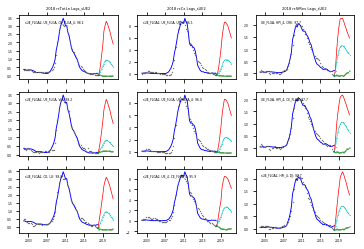

In [122]:
## top3 3-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

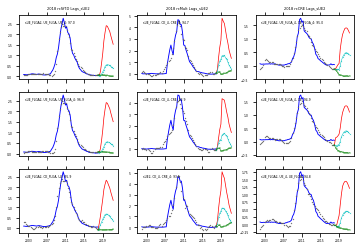

In [123]:
## top3 3-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

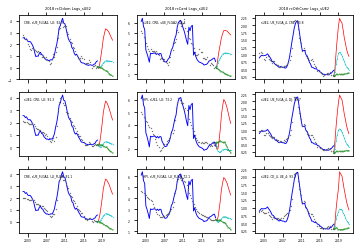

In [124]:
## top3 3-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [125]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v,\
                       data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [126]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 2-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 3-var models
df4b.index = np.arange(len(df4b))

In [127]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names

  if x == 0:
    frt4b = frt2.copy()
  else:
    frt4b = frt4b.merge(frt2, how='outer', left_index=True, right_index=True)

In [128]:
frt2.head()

rcTotLn2                              
              Actual       Fit Base Adverse SevAdv
Date                                              
2001-12-31  0.369825  0.373266  NaN     NaN    NaN
2002-03-31  0.368455  0.400962  NaN     NaN    NaN
2002-06-30  0.316610  0.339341  NaN     NaN    NaN
2002-09-30  0.320374  0.306574  NaN     NaN    NaN
2002-12-31  0.341797  0.269288  NaN     NaN    NaN

In [129]:
frt4s = pd.DataFrame(frt4b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt4s.reset_index(drop=False, inplace=True)
frt4s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt4s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
####################################################################
#   NOTE:  this section will determine ordering of models in charts:
#          3 options: (1) r-sq, (2) SevAdv, or (3) differential bet SevAdv and Base
#frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv['diff'] = frpv.apply(lambda x: x['SevAdv']-max(0,x['Base']),axis=1)
#frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
####################################################################
frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True) # use for diff = SevAdv or SevAdv-Base
#frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
####################################################################
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.tail(9)

scen          rc    Actual    Adverse       Base       Fit     SevAdv  \
22       rcCard0  2.227767  24.865886  14.093962  1.748479  37.603308   
21       rcCard1  2.227767  24.185476  13.398493  1.663551  36.939247   
23       rcCard2  2.227767  17.232523  21.137061  2.359375  34.832568   
26    rcOthCsmr0  0.467475   5.914579   2.025607  0.256769  12.075475   
25    rcOthCsmr1  0.467475   6.371186   2.188158  0.260644  12.694508   
24    rcOthCsmr2  0.467475   7.155704   2.661129  0.232088  13.836442   
29     rcCREtot0  0.033018   3.734783  -2.120009 -0.106288  16.214959   
28     rcCREtot1  0.033018   3.948063  -1.964988 -0.130783  16.615160   
27     rcCREtot2  0.033018   5.457919  -3.150717 -0.235925  18.189857   

scen        rc2  ord       diff  rk  
22       rcCard    7  23.509346   1  
21       rcCard    7  23.540753   0  
23       rcCard    7  13.695507   2  
26    rcOthCsmr    8  10.049869   2  
25    rcOthCsmr    8  10.506350   1  
24    rcOthCsmr    8  11.175314   0  
29     rcCREtot    9  18.334969   2  
28     rcCREtot    9  18.580148   1  
27     rcCREtot    9  21.340574   0

In [130]:
df4bc = df4b.copy()
df4bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df4bc['rc'] = df4bc.index % topn
df4bc['rc'] = df4bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df4bc = df4bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df4bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df4bc.reset_index(drop=True, inplace=True)
df4bc['Desc'] = grp+"_"+str(ccar)+"_4v9"+styp
df4bc.tail(9)

rc2         v1        r1         v2        r2         v3        r3  \
21     rcCard       sUE2  0.533443        CRE  0.640938  sUE_FLGA2  0.744072   
22     rcCard       sUE2  0.533443        CRE  0.640938  sUE_FLGA2  0.744072   
23     rcCard        HPI  0.547112       sUE2  0.642674         UE  0.732156   
24  rcOthCsmr       sUE2  0.628654       CE_4  0.909167       UE_4  0.933159   
25  rcOthCsmr       sUE2  0.628654       CE_4  0.909167       UE_4  0.933159   
26  rcOthCsmr       sUE2  0.628654  UE_FLGA_4  0.927499        CRE  0.937695   
27   rcCREtot  sUE_FLGA2  0.953528  CE_FLGA_4  0.970172         UE  0.979380   
28   rcCREtot  sUE_FLGA2  0.953528  CE_FLGA_4  0.970172         UE  0.979380   
29   rcCREtot  sUE_FLGA2  0.953528  CE_FLGA_4  0.970172        HPI  0.978245   

           v4        r4        Int        c1        c2        c3        c4  \
21       UE_4  0.776349  10.633142 -0.139668 -0.027002  0.123542 -0.231008   
22  UE_FLGA_4  0.766769  10.197434 -0.146623 -0.026682  0.128553 -0.160228   
23        CRE  0.735764  19.994255 -0.040061  0.224131 -2.971837 -0.004963   
24      HPI_4  0.946445  -0.859165  0.022716  0.366190 -0.102199 -0.002692   
25        CRE  0.944569  -0.385883  0.022510  0.271010 -0.116334 -0.001609   
26        VIX  0.942366   0.967770  0.025261 -0.155114 -0.001540  0.003305   
27  UE_FLGA_4  0.987357  -1.589566  0.056402  0.332853 -0.453230  0.136977   
28       UE_4  0.986834  -1.225944  0.058741  0.273403 -0.468530  0.132422   
29  UE_FLGA_4  0.980486  -3.887552  0.039218  0.263543  0.006583  0.071804   

            rc  ord  rk                           Desc  
21     rcCard0    7   1  grpFLGAx18x_2018_4v9Lags_sUE2  
22     rcCard1    7   0  grpFLGAx18x_2018_4v9Lags_sUE2  
23     rcCard2    7   2  grpFLGAx18x_2018_4v9Lags_sUE2  
24  rcOthCsmr0    8   2  grpFLGAx18x_2018_4v9Lags_sUE2  
25  rcOthCsmr1    8   1  grpFLGAx18x_2018_4v9Lags_sUE2  
26  rcOthCsmr2    8   0  grpFLGAx18x_2018_4v9Lags_sUE2  
27   rcCREtot0    9   2  grpFLGAx18x_2018_4v9Lags_sUE2  
28   rcCREtot1    9   1  grpFLGAx18x_2018_4v9Lags_sUE2  
29   rcCREtot2    9   0  grpFLGAx18x_2018_4v9Lags_sUE2

In [131]:
frt4b.to_csv(grp + "_"  + str(ccar) +'_4v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df4bc.to_csv(grp + "_"  + str(ccar) + '_4v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2018

In [132]:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(df4bc)):
  ds1 = df4bc.ix[i]['v1'] + ', ' + df4bc.ix[i]['v2'] + ', ' + df4bc.ix[i]['v3'] + ','
  ds2 = df4bc.ix[i]['v4'] +': '+ str(round(df4bc.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

df4bc['Annot1'] = df4lst1
df4bc['Annot2'] = df4lst2
df4bc[0:2]

rc2         v1        r1       v2        r2         v3        r3   v4  \
0  rcTotLn  sUE_FLGA2  0.947662  UE_FLGA  0.975196  CE_FLGA_4  0.982336  VIX   
1  rcTotLn  sUE_FLGA2  0.947662  UE_FLGA  0.975196        VIX  0.982252   CE   

         r4       Int        c1        c2        c3        c4        rc  ord  \
0  0.984075  0.597269  0.062409 -0.492621  0.067654  0.004965  rcTotLn0    0   
1  0.983792  0.050479  0.063588 -0.496494  0.005419  0.183812  rcTotLn1    0   

   rk                           Desc                          Annot1  \
0   1  grpFLGAx18x_2018_4v9Lags_sUE2  sUE_FLGA2, UE_FLGA, CE_FLGA_4,   
1   0  grpFLGAx18x_2018_4v9Lags_sUE2        sUE_FLGA2, UE_FLGA, VIX,   

      Annot2  
0  VIX: 98.4  
1   CE: 98.4

In [133]:
##################################################################################
# select highest R-squared model:
#md = [0,0,0,0,0,0,0,0,0]  # note: use this to rank based on R-squared
#mdr = [x for x in list(df4bc['rc']) if x[-1]=='0']

# special code to select "best" model based on max 9q diff between SevAdv and Base forecasts:
md=list(df4bc[df4bc['rk']==0]['rc'])  # note: use this if you want models based on diff calc (SevAdv - Bas ranking)
mdr = [x[-1] for x in md]

mdr, md

(['1', '1', '2', '0', '2', '1', '2', '1', '2', '2'],
 ['rcTotLn1',
  'rcCx1',
  'rcSfRev2',
  'rcSfTD0',
  'rcMult2',
  'rcCRE1',
  'rcCIdom2',
  'rcCard1',
  'rcOthCsmr2',
  'rcCREtot2'])

In [134]:
curlst

['rcTotLn',
 'rcCx',
 'rcSfRev',
 'rcSfTD',
 'rcMult',
 'rcCRE',
 'rcCIdom',
 'rcCard',
 'rcOthCsmr',
 'rcCREtot']

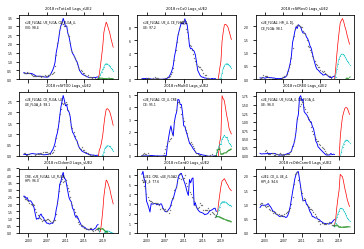

In [135]:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

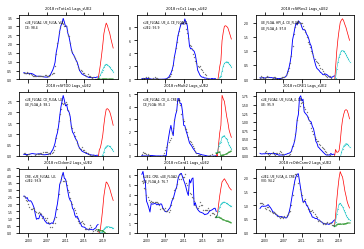

In [136]:
## special version for TotUSx18 only... best version based on diff bet SevAdv and Base:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

#ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

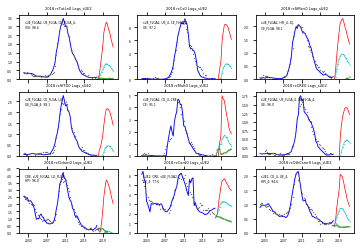

In [137]:
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

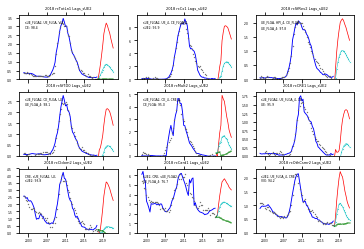

In [138]:
## special version for 2013 TotUSx18 only... best diff sevadv - base (9q only)
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.ylim(ymin=0)

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

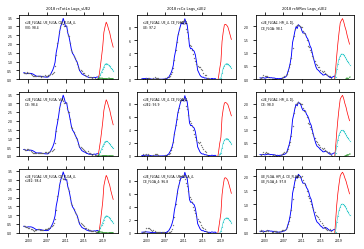

In [139]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

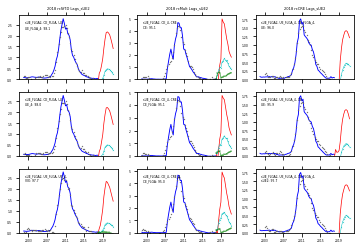

In [140]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

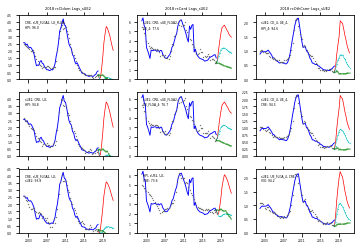

In [141]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [142]:
## repeat triple charts cutting off actual and fitted to prior Sept (9/30/2012 for 2013 CCAR)

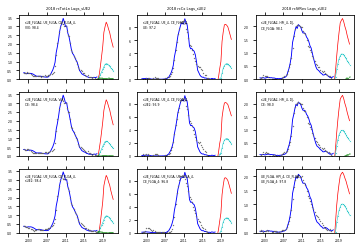

In [143]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

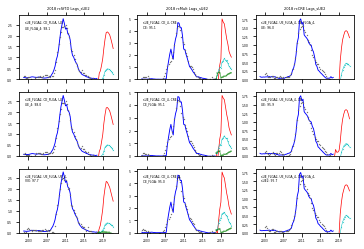

In [144]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

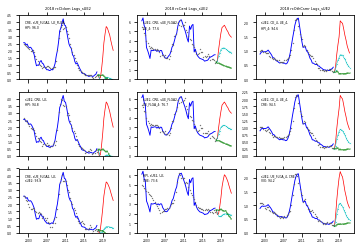

In [145]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',ms=1.2,mew=.25,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [146]:
## section to calculate volumes of NCOs from the forecasted NCO rates:

In [147]:
nmlst = ['qncTotLn','qncCx','qncSfRev','qncSfTD','qncMult','qncCRE','qncCIdom','qncCard','qncOthCsmr','qncCREtot'] # numerators in vofi
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] # denominators in vofi

nmz = dict(zip(rclst, nmlst))
dmz = dict(zip(rclst, dmlst))

#col names to use:
fv = "Fv"  # Fitted model volumes
bv = "Bv"  # Base scenario volumes
av = "Av"  # Adverse scenario volumes
sv = "Sv"  # SevAdv scenario volumes
fm = "Fit"  # these last 4 are model outputs for fitted model & 3 scenarios
bm = "Base"
am = "Adverse"
svm = "SevAdv"  ######### changed on 12/8/15 from sm to svm to avoid statsmodels abbreviation

In [148]:
grporig, styp, irflg

('grpFLGAx18x', 'Lags_sUE2', '_NoRates')

In [149]:
## volumes file:
vofi = "df2_3z_"+grporig+".csv"            ## history volumes file for groups to analyze
vo = pd.read_csv(vofi, index_col=0)
vo = vo[vo['Grp']==grp]
vo.rename(columns={"AsOf":"Date"}, inplace=True)
vo['Date'] = pd.to_datetime(vo['Date'])
vo.set_index('Date',drop=True,inplace=True)

dfz1 = []
dfz3 = []

In [150]:
#vv = 2  ## 0,1,2 only:  selects vlst item

#mn = 1 # single models per rc ("full" files)
#mn = 3 # 3 vars per rc ("3v" files)
mn = 4 # 4 vars per rc ("4v" files)

#rkfi = pd.read_csv(grp+'_allyr_' + str(rtyp) +'_'+str(mn)+'v10best_'+cbo[vv]+'.csv', index_col=0)
#rkfi.set_index('ccar',drop=True, inplace=True)

In [151]:
if ccar <= 2015:
  dttr = str(ccar-1) + "-09-30"  # transition date (3rd qtr of year prior to CCAR year)
  dtst = str(ccar-1) + "-12-31"  # start of 9q forecast period
  dten = str(ccar+1) + "-12-31"  # end of 9q forecast period
else:
  dttr = str(ccar-1) + "-12-31"  # transition date (3rd qtr of year prior to CCAR year)
  dtst = str(ccar) + "-03-31"  # start of 9q forecast period
  dten = str(ccar+2) + "-03-31"  # end of 9q forecast period

if ccar >= 2016: 
  vo = vo.ix[:dttr]  # special handling for CCAR years after 2015
else:
  vo = vo.ix[:"2014-12-31"]  # conforms to book exhibits

if mn == 1:
  mtyp = '_full_'
elif mn == 3:
  mtyp = '_3v_'
elif mn == 4:
  mtyp = '_4v_'
else:
  mtyp = 'xxx'  # force error to fix problem
  
hdrw = [0,1] # indicates first 2 rows in forecast file "rtfi" have col headings
  
rtfi = grp + "_" + str(ccar) + mtyp + "9fcst_" + rtyp +"_" + styp +irflg + ".csv" ## file with modeled ccar forecast nco/fail rates
rt = pd.read_csv(rtfi, index_col=0, header=hdrw, parse_dates=True)
  
paramfi = grp + "_" + str(ccar) + mtyp + "9param_" + rtyp +"_"  + styp +irflg + ".csv"  ## param file for same run
param = pd.read_csv(paramfi, index_col=0, header=0)
param.index.name= 'scen'
  
### start prod loops here:
balst= []
dmlst = []

In [152]:
param.head(2)

rc2         v1        r1       v2        r2         v3        r3  \
scen                                                                         
0     rcTotLn  sUE_FLGA2  0.947662  UE_FLGA  0.975196  CE_FLGA_4  0.982336   
1     rcTotLn  sUE_FLGA2  0.947662  UE_FLGA  0.975196        VIX  0.982252   

       v4        r4       Int        c1        c2        c3        c4  \
scen                                                                    
0     VIX  0.984075  0.597269  0.062409 -0.492621  0.067654  0.004965   
1      CE  0.983792  0.050479  0.063588 -0.496494  0.005419  0.183812   

            rc  ord  rk                           Desc  
scen                                                    
0     rcTotLn0    0   1  grpFLGAx18x_2018_4v9Lags_sUE2  
1     rcTotLn1    0   0  grpFLGAx18x_2018_4v9Lags_sUE2

In [153]:
#for pr in np.arange(2):
for pr in np.arange(len(rt.columns.levels[0])):
  if mn > 1:
    prn = rclst[int(pr/topn)]+str(pr % topn)  # add rank suffix to prodname
  else:
    prn = rclst[int(pr/topn)]    ## just use prodname
  prnm = rclst[int(pr/topn)]     ## prod name (no rank suffix)
  drt = rt[prn]
  df = vo[[nmz[prnm],dmz[prnm]]]
  df.columns = ['nco','bal']
  
  dfr = df.merge(drt, how='outer', left_index=True, right_index=True)
  
  # seed early rows of vol cols with actuals, then calc model vols for forecast periods:
  dfr['Fv'] = dfr['nco']  # added 12/12
  dfr['Bv'] = dfr['nco']
  dfr['Av'] = dfr['nco']
  dfr['Sv'] = dfr['nco']
  
  dfr['bal'] = dfr['bal'].fillna(method='pad')
  dfr[[bm,am,svm]] = dfr[[bm,am,svm]].fillna(-999)
  
  dfr.ix[dttr][bm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][bm] == -999:
      dfr.ix[x][bv] = dfr.ix[x].nco
      dfr.ix[x][fv] = dfr.ix[x].nco # added 12/12
    else:
      if rtyp == "4q":
        dfr.ix[x][bv] = dfr.ix[x][bm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][bv] +dfr.ix[x-2][bv] +dfr.ix[x-3][bv])
        dfr.ix[x][fv] = dfr.ix[x][fm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][fv] +dfr.ix[x-2][fv] +dfr.ix[x-3][fv])  # added 12/12
      else:
        dfr.ix[x][bv] = dfr.ix[x][bm] * dfr.ix[x].bal/400 
        dfr.ix[x][fv] = dfr.ix[x][fm] * dfr.ix[x].bal/400  # added 12/12
  
  dfr.ix[dttr][am] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][am] == -999:
      dfr.ix[x][av] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][av] = dfr.ix[x][am] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][av] +dfr.ix[x-2][av] +dfr.ix[x-3][av])
      else:
        dfr.ix[x][av] = dfr.ix[x][am] * dfr.ix[x].bal/400 
  
  dfr.ix[dttr][svm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][svm] == -999:
      dfr.ix[x][sv] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][sv] = dfr.ix[x][svm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][sv] +dfr.ix[x-2][sv] +dfr.ix[x-3][sv])
      else:
        dfr.ix[x][sv] = dfr.ix[x][svm] * dfr.ix[x].bal/400 
  
  ## NEW SECTION:
  dfr.replace(to_replace=-999, value=np.nan, inplace=True)  ## replace -999 with nan
  for i in np.arange(len(dfr)):     ## remove forecast Adverse vol if there is no Adverse scenario
    if dfr.iloc[i].name >= pd.to_datetime(dtst):  ## check that this is a forecast period, not history
      if np.isnan(dfr.ix[i]['Adverse']):
        dfr.ix[i]['Av'] = np.nan
  
  dfv = dfr[['Bv','Av','Sv']].ix[dtst:dten].sum()  # 9q forecasts (ignore nco, Fv) 
  
  r9q = dfr['2006-12-31':dtst]['nco'].rolling(9, min_periods=9).sum()
  r9q = r9q.dropna()
  r9qm = r9q[r9q==r9q.max()]  # largest 9q losses in history
  
  dfv2 = pd.DataFrame(dfv, columns=[prn])
  dfv2.ix['ActMx'] = r9qm.values[0]
  dfv2.ix['DateMx'] = r9qm.index[0]
  dfv2t = dfv2.T
  dfv2t.reset_index(drop=False, inplace=True)
  
  b9q = dfr['2006-12-31':dtst]['bal'].rolling(9, min_periods=9).mean()
  balst = balst + [b9q.ix[r9qm.index[0]]]  ## avg bal for max actual charge-offs
  
  dmlst = dmlst + [dfr['bal'].ix[dtst:dten].mean()]  ## avg bal during CCAR periods
#  voldet = dfr.ix[str(ccar-1)+'-01-01':]
  voldet = dfr.ix[str(ccar-3)+'-01-01':]
  voldet.columns = pd.MultiIndex.from_product([[prn], list(voldet.columns)])
  
  if pr == 0:
    dfvr = dfv2t
    voldet2 = voldet.copy()
  else:
    dfvr = pd.concat([dfvr, dfv2t],ignore_index=True)
#    voldet2 = voldet2.merge(voldet, how='left', left_index=True, right_index=True)
    voldet2 = pd.concat([voldet,voldet2],ignore_index=True,axis=1)

In [154]:
dfvr

index       Bv           Av           Sv        ActMx  \
0     rcTotLn0  87101.8  3.17699e+06  1.17102e+07  9.21154e+06   
1     rcTotLn1  -152151  2.99029e+06  1.17688e+07  9.21154e+06   
2     rcTotLn2  -119074  3.37478e+06  1.15073e+07  9.21154e+06   
3        rcCx0  -350333       410470  1.92163e+06   4.6444e+06   
4        rcCx1  -538846       470804  1.91083e+06   4.6444e+06   
5        rcCx2  -435025       373058  1.93667e+06   4.6444e+06   
6     rcSfRev0 -19474.3       144172       364023       283586   
7     rcSfRev1   -18282       149541       367761       283586   
8     rcSfRev2 -60420.3       148088       352577       283586   
9      rcSfTD0  -441087       279322  2.07901e+06  1.28843e+06   
10     rcSfTD1  -390044       321048  2.09926e+06  1.28843e+06   
11     rcSfTD2  26153.9       369793  2.19067e+06  1.28843e+06   
12     rcMult0  96500.2       321566       712748       379099   
13     rcMult1  52266.7       287827       720531       379099   
14     rcMult2  43301.7       309823       769412       379099   
15      rcCRE0  -387606       181676  1.18239e+06  1.53866e+06   
16      rcCRE1  -524361      84569.3  1.25732e+06  1.53866e+06   
17      rcCRE2  -525273       221020   1.1771e+06  1.53866e+06   
18    rcCIdom0 -4709.79     -56096.2    1.275e+06       858545   
19    rcCIdom1   131428     -60906.6  1.29362e+06       858545   
20    rcCIdom2 -77476.1        76968  1.24694e+06       858545   
21     rcCard0  17549.4      39691.6      65332.1        84594   
22     rcCard1  16208.6      38694.1      64731.4        84594   
23     rcCard2  31282.9      25505.8      64089.1        84594   
24  rcOthCsmr0  20949.6       111577       264552       204701   
25  rcOthCsmr1  25058.8       120410       273034       204701   
26  rcOthCsmr2  38702.6       134704       287039       204701   
27   rcCREtot0  -680624  1.32481e+06  5.57007e+06  6.35908e+06   
28   rcCREtot1  -620895  1.37283e+06  5.64056e+06  6.35908e+06   
29   rcCREtot2  -953472  1.77263e+06  5.96379e+06  6.35908e+06   

                 DateMx  
0   2010-12-31 00:00:00  
1   2010-12-31 00:00:00  
2   2010-12-31 00:00:00  
3   2010-12-31 00:00:00  
4   2010-12-31 00:00:00  
5   2010-12-31 00:00:00  
6   2010-12-31 00:00:00  
7   2010-12-31 00:00:00  
8   2010-12-31 00:00:00  
9   2011-06-30 00:00:00  
10  2011-06-30 00:00:00  
11  2011-06-30 00:00:00  
12  2010-12-31 00:00:00  
13  2010-12-31 00:00:00  
14  2010-12-31 00:00:00  
15  2011-12-31 00:00:00  
16  2011-12-31 00:00:00  
17  2011-12-31 00:00:00  
18  2010-12-31 00:00:00  
19  2010-12-31 00:00:00  
20  2010-12-31 00:00:00  
21  2012-03-31 00:00:00  
22  2012-03-31 00:00:00  
23  2012-03-31 00:00:00  
24  2010-03-31 00:00:00  
25  2010-03-31 00:00:00  
26  2010-03-31 00:00:00  
27  2010-12-31 00:00:00  
28  2010-12-31 00:00:00  
29  2010-12-31 00:00:00

In [155]:
voldet.head(2)

rcCREtot2                                                      \
                 nco         bal    Actual       Fit Base Adverse SevAdv   
Date                                                                       
2015-03-31   21236.0  73859472.0  0.179439  0.275178  NaN     NaN    NaN   
2015-06-30    8447.0  75853267.0  0.127423  0.205851  NaN     NaN    NaN   

                                                
                 Fv       Bv       Av       Sv  
Date                                            
2015-03-31  21236.0  21236.0  21236.0  21236.0  
2015-06-30   8447.0   8447.0   8447.0   8447.0

In [156]:
if mn > 1:
  dfvr2 = dfvr.copy()
  dfvr2['bal'] = dmlst
  dfvr2['ActBalMx'] = balst
  dfvr2['rk']  = dfvr2.index % mn
  dfvr2['rk'] += 1
  
  dfvr2t = dfvr2.copy()
  dfvr2t['ActMxRt'] = dfvr2t['ActMx']*100/(dfvr2t['ActBalMx']+.000001)
  dfvr2t['ModRt'] = dfvr2t['Sv']*100/(dfvr2t['bal']+.000001)
  dfvr2t = dfvr2t[['index','bal','Bv','Av','Sv','ActMx','ActBalMx','DateMx','ActMxRt','ModRt']] # chgd 12/12 'Fv'
  dfvr2t['Diff'] = dfvr2t['Sv'] - dfvr2t['Bv']
  dfvr2t['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp + styp
  dfvr2t.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_vol.csv")
  voldet2.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_voldet.csv")
  dfz3 = dfvr2t.copy()
  
if mn == 1:
  dfvr['bal'] = dmlst
  dfvr['ActBalMx'] = balst
  dfvr[['Bv','Av','Sv','ActMx']] = dfvr[['Bv','Av','Sv','ActMx']].astype(float)
  
  dfvrt = dfvr.copy()
  dfvrt['ActMxRt'] = dfvrt['ActMx']*100/dfvrt['ActBalMx']
  dfvrt['ModRt'] = dfvrt['Sv']*100/dfvrt['bal']
  dfvrt['Diff'] = dfvrt['Sv'] - dfvrt['Bv']
  dfvrt['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp +"_"+ styp
  dfvrt.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv")
  voldet.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_voldet.csv")
  dfz1 = dfvrt.copy()

In [157]:
voldet.head()

rcCREtot2                                                      \
                 nco         bal    Actual       Fit Base Adverse SevAdv   
Date                                                                       
2015-03-31   21236.0  73859472.0  0.179439  0.275178  NaN     NaN    NaN   
2015-06-30    8447.0  75853267.0  0.127423  0.205851  NaN     NaN    NaN   
2015-09-30    9627.0  78311521.0  0.100881  0.104577  NaN     NaN    NaN   
2015-12-31   10444.0  80166429.0  0.064576  0.030788  NaN     NaN    NaN   
2016-03-31   -3489.0  81762433.0  0.031673 -0.021912  NaN     NaN    NaN   

                                                
                 Fv       Bv       Av       Sv  
Date                                            
2015-03-31  21236.0  21236.0  21236.0  21236.0  
2015-06-30   8447.0   8447.0   8447.0   8447.0  
2015-09-30   9627.0   9627.0   9627.0   9627.0  
2015-12-31  10444.0  10444.0  10444.0  10444.0  
2016-03-31  -3489.0  -3489.0  -3489.0  -3489.0

In [158]:
grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv"

'grpFLGAx18x_2018_4v_4q_Lags_sUE2_NoRates_vol.csv'

In [159]:
grp = grporig  # reset to original grp designation
grp, styp, irflg, ccar

('grpFLGAx18x', 'Lags_sUE2', '_NoRates', 2018)